In [2]:
import pandas as pd
import numpy as np

from IPython.display import SVG
from rdkit.Chem.Draw import IPythonConsole
import joblib
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from IPython.display import HTML
from scipy.spatial.distance import pdist, cdist
%pylab inline

from __future__ import division

Populating the interactive namespace from numpy and matplotlib


In [3]:
pwd

u'/Users/oliverwatson/MalariaPaper'

## Introduction

This notebook is meant to accompany the paper _Model Extrapolation on Malaria Data_ - currently in preparation - so that all results can easily be replicated.

Contents are as follows:
- Data discussion
- Digression on Tanimoto distance
- Bias correction
- MPO optimization


## Data discussion

We have three main datasets.  Firstly - the one avaliable here on chembl gitbook

A. https://chembl.gitbook.io/chembl-ntd/downloads/deposited-set-1-gsk-tcams-dataset-20th-may-2010

We will refer to this henceforth as the **TCAMS dataset**, although it is actually some combination of TCAMS and other Chembl data.  

We also have:

B. The chembl data associated to the malaria assays (downloaded from the webclient, code in Appendix)

We'll refer to this as the **Plasmodium datset**.  In this section we'll talk about the advantages and disadvantages of each dataset - and how we can use them together.

Finally we have two quite different datasets - which we will use for the purposes of sanity checking the datasets above, and testing - insofar as we can - the predictions we make from them:

C.  A list of 7 well-known malaria drugs.

D.  Roughly 7.5 million commercially available compounds from Molport.

In terms of generating these datasets - see code in malaria/utils - which generates the following two files:

 * parsed/chembl_tcams.pkl (this is just downloaded as csv, gets standardised fingerprints added, and is then pickled)
 * parsed/chembl_isidro.pkl
 
 
 We will not be adding the Molport data (we don't have permission, and it is too big anyway to fit onto git). Thus the final parts of this work won't be reproducible from git.

In [4]:
df_tcams = pd.read_pickle('parsed/chembl_tcams.pkl')
df_plas = pd.read_pickle('parsed/chembl_isidro.pkl')

The TCAMS data has two columns that will be of main interest to us:
- pXC50_3D7: pIC50 values against the (3D7) strain of _Plasmodium Falciparum_.  Henceforth we will refer to this value (and the similar variable available in the Plasmodium dataset) as **Potency**.
- PCT_INHIB_HEPG2: percent inhibition against HEPG2 cells, henceforth referred to as **Toxicity**.

The Plasmodium dataset only has potency values.

Both datsets have Chembl compound IDs and SMILES associated to them.  To both datasets we associate canonical smiles as calculated by our own standardiser software, to ensure uniqueness.  From these canonical smiles we then separately calculate 128 bit _binary fingerprints_ and 128 bit _hashed fingerprints_.  These will be the predictors used in the subsequent analysis.  We also use these canonical smiles to look at the uniqueness and overlap between these two datasets, which we now describe.

#### Potency, selection, uniqueness and overlap in TCAMS and Plasmodium datasets

Following list of facts about TCAMS datsets is inferred from code run below:

In [5]:
from malaria import utils, stats
from standardiser import standardise

mrgd_df = pd.merge(df_plas.groupby('SMILESIS').mean(), 
                   df_tcams.groupby('SMILESIS').mean(), left_index=True, right_index=True)

tcams_good_pot = np.sum(~np.isnan(df_tcams.groupby('SMILESIS').mean()['pXC50_3D7'].values))
tcams_good_tox = np.sum(~np.isnan(df_tcams.groupby('SMILESIS').mean()['PCT_INHIB_HEPG2'].values))

print('TCAMS rows                              %d' % df_tcams.shape[0])
print('TCAMS unique Canonical smiles:          %d' % np.unique(df_tcams.SMILESIS.values).shape[0])
print('TCAMS unique CS with value for potency  %d' % tcams_good_pot)
print('TCAMS unique CS with value for toxicity %d' % tcams_good_tox)
print('')
print('PLASM rows                              %d' % df_plas.shape[0])
print('PLASM unique CS (all have potency val)  %d' % np.unique(df_plas.SMILESIS.values).shape[0])
print('')
print('Number unique CS in TCAMS AND PLASM     %d' % mrgd_df.shape[0])
print('')
print('Regression of POT on intersection TCAMS/PLASM')
gd = ~np.isnan(mrgd_df.pXC50_3D7.values)
stats.regress(mrgd_df.VAL.values[gd], [mrgd_df.pXC50_3D7.values[gd],])

TCAMS rows                              26784
TCAMS unique Canonical smiles:          21005
TCAMS unique CS with value for potency  13327
TCAMS unique CS with value for toxicity 13237

PLASM rows                              23864
PLASM unique CS (all have potency val)  18162

Number unique CS in TCAMS AND PLASM     13090

Regression of POT on intersection TCAMS/PLASM
Coeffs:       1.0004 
R-squared:    0.9749


In [6]:
#gd = ~np.isnan(df_tcams.pXC50_3D7.values)
#full_df = pd.DataFrame.from_dict({'SMILESIS' : list(df_plas.SMILESIS.values) + list(df_tcams.SMILESIS.values[gd]), 
#                                 'POTENCY'  : list(df_plas.VAL.values) + list(df_tcams.pXC50_3D7.values[gd]),
#                                 })
#full_df = full_df.groupby('SMILESIS').mean()
#fps = [utils.get_fp(x) for x in full_df.index]
#full_df['fps'] = pd.Series([np.asarray(fp).astype(bool) for fp in fps], index=full_df.index)
#hfps = [utils.get_fp(x, hashed=True) for x in full_df.index]
#full_df['hfps'] = pd.Series([np.asarray(fp) for fp in hfps], index=full_df.index)
#crippen = pd.Series([utils.get_crippen(Chem.MolFromSmiles(x)) for x in full_df.index], index=full_df.index)
#qed = pd.Series([utils.get_qed(Chem.MolFromSmiles(x)) for x in full_df.index], index=full_df.index)
#full_df['crippen'] = crippen
#full_df['qed'] = qed
#full_df.to_pickle('joined_chembl_data.pkl')
full_df = pd.read_pickle('joined_chembl_data.pkl')

In [7]:
full_df.shape

(18425, 5)

Some things to note...
* There is some data in the TCAMS dataset that isn't in the general dataset (since the full datset has a few hundred more points than the general dataset).  Thus it isn't the case that querying on the malaria assays (including GSK/TCAMS) just accesses this dataset 'behind the hood'.
* We get more than 5000 extra compounds (for Potency) by using the general dataset (though we only have toxicity from the TCAMS dataset). This is why it makes sense to use both (and to check that they are the same/very similar dataset on the overlap)

In fact - what we see below is that if we restrict to the cases in the plasmodium dataset where there are as many different values as in the TCAMS dataset, we get almost identical values.  In the (small number) of cases where the two datasets both have values, but the plasmodium dataset has _more_ different values, then the beta is still 1.0, but the r^2 is much lower.

In [8]:
mrgd_df4 = pd.merge(mrgd_df,
                    pd.merge(df_plas.groupby('SMILESIS')[['VAL']].count(), 
                    df_tcams.groupby('SMILESIS')[['pXC50_3D7']].count(), 
                    left_index=True, right_index=True),
                    suffixes=('', '_ct'), left_index=True, right_index=True)

In [9]:
# Cases where there are more values for a given smile in plasmodium dataset than in tcams
mdf5 = mrgd_df4.loc[mrgd_df4['VAL_ct'] > mrgd_df4['pXC50_3D7_ct']]
gd = ~np.isnan(mdf5.VAL.values) & ~np.isnan(mdf5.pXC50_3D7.values)
stats.regress(mdf5.VAL.values[gd], [mdf5.pXC50_3D7.values[gd],])

Coeffs:       1.0116 
R-squared:    0.3433


In [10]:
# cases where there are the same number of values
mdf6 = mrgd_df4.loc[mrgd_df4['VAL_ct'] == mrgd_df4['pXC50_3D7_ct']]
gd = ~np.isnan(mdf6.VAL.values) & ~np.isnan(mdf6.pXC50_3D7.values)
stats.regress(mdf6.VAL.values[gd], [mdf6.pXC50_3D7.values[gd],])

Coeffs:       1.0000 
R-squared:    0.9997


Let's also add data on our standard anti-malarial drugs

In [11]:
Artemisinin = 'CC1CCC2C(C(=O)OC3C24C1CCC(O3)(OO4)C)C'
Atovaquone  = 'C1CC(CCC1C2=CC=C(C=C2)Cl)C3=C(C4=CC=CC=C4C(=O)C3=O)O'
Chloroquine = 'CCN(CC)CCCC(C)NC1=C2C=CC(=CC2=NC=C1)Cl'
Doxycycline = 'CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4O)O)O)O)C(=O)N)N(C)C)O'
Mefloquine  = 'C1CCNC(C1)C(C2=CC(=NC3=C2C=CC=C3C(F)(F)F)C(F)(F)F)O'
Primaquine  = 'CC(CCCN)NC1=C2C(=CC(=C1)OC)C=CC=N2'
Piperaquine = 'C1CN(CCN1CCCN2CCN(CC2)C3=C4C=CC(=CC4=NC=C3)Cl)C5=C6C=CC(=CC6=NC=C5)Cl'
drugs = [Artemisinin, Atovaquone, Chloroquine, Doxycycline, Mefloquine, Primaquine, Piperaquine]
drugs = [standardise.run(drug) for drug in drugs]
drug_labels = ['Artemisinin', 'Atovaquone', 'Chloroquine', 
               'Doxycycline', 'Mefloquine', 'Primaquine', 'Piperaquine']


Note - Doxycycline and Piperaquine aren't in our dataset - although something very similar to Piperaquine is (but nothing that close to Doxycycline). The others all are.

In [12]:
cd = cdist(np.asarray([x for x in full_df.fps.values]), np.asarray([utils.get_fp(d) for d in drugs]),
           metric='jaccard')
np.min(cd, axis=0)

array([ 0.        ,  0.        ,  0.        ,  0.43548387,  0.        ,
        0.        ,  0.0625    ])

We should make some further comments about the potency data before going any further.

In the TCAMS dataset, there are no values for potency below ~ 5.3.  This might lead one to think that any missing potency data is inactive.  However - this would be a bad assumption.  We checked for the best current known anti-malarial drugs (described in the next section).  All of these bar one (Doxycycline) are in the TCAMS dataset, **however**, **only two** have non-nan potency values (Chloroquine has two) - and the most potent known drug, Artemisinin has no potency value assigned.

Therefore it is clear that adding data to the TCAMS dataset is going to be necessary, but given its biases, our overall dataset will still be heavily biased, and in particularly very strongly biased towards predicting potency values that are unreasonably high.

Note that we go get potency values for all drugs in our merged dataset apart from Doxycycline and Piperaquine (and we do have a close match to Piperaquine).

Below we show the potency histogram of our full merged dataset:

### BREAK with previous paper - switch full_df = df_tcams.

In [13]:
# Add all the data to the Tcams no dups...
#df_tcams_nd = df_tcams.groupby('SMILESIS').mean()
df_tcams_nd = pd.read_pickle('parsed/tcams_nodups.pkl')
full_df = df_tcams_nd.copy()
full_df.rename(columns={'pXC50_3D7' : 'POTENCY'}, inplace=True)

### Figure 1.

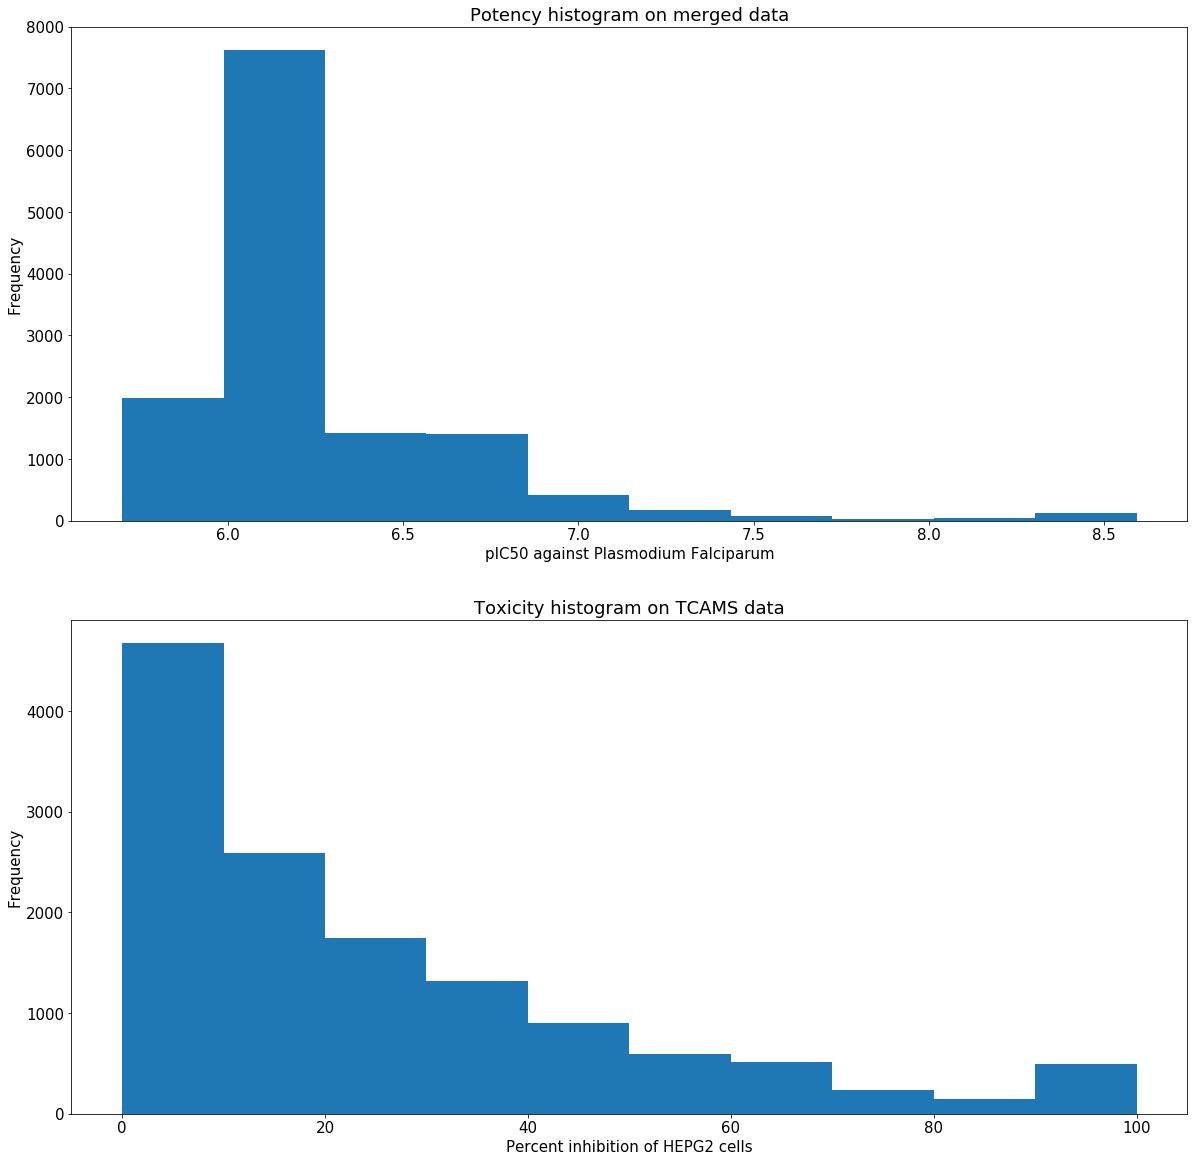

In [14]:
# Figure 1 in the paper
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20))
plt.subplot(211)
full_df.POTENCY.plot.hist()
_ = plt.title('Potency histogram on merged data')
plt.xlabel('pIC50 against Plasmodium Falciparum')
plt.subplot(212)
df_tcams.groupby('SMILESIS').mean()['PCT_INHIB_HEPG2'].plot.hist()
plt.xlabel('Percent inhibition of HEPG2 cells')
_ = plt.title('Toxicity histogram on TCAMS data')
savefig('figures/fig1_hists.png')

### 3. Modelling.

We will only report the main modelling results we obtained. In particular - we will do 'naive' in/out-of-sample testing, having done nothing but remove duplicates in order to force our two sets to be distinct.  

Let's just look at the performance of Naive Random forest performance on the whole dataset, together with a plot...

In [15]:
vls = np.asarray([x for x in full_df.fps.values])

In [16]:
np.isnan(vls).any()

False

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, RidgeCV

model_dict = {'ridge' : {'m': Ridge, 'kw': {'fit_intercept': True, 'alpha': 0.1}},
              'rcv':  {'m': RidgeCV, 'kw': {'cv': 5}},
              'rf': {'m': RandomForestRegressor, 'kw': {'n_estimators': 100, 'n_jobs': 4, 'max_depth': 10}}}

method = 'rf'
mdl = model_dict[method]['m'](**model_dict[method]['kw'])

In [18]:
gd = ~np.isnan(full_df.POTENCY.values)

In [19]:
full_df.shape

(21005, 19)

In [20]:
preds = np.asarray([x for x in full_df.fps[gd]])

In [21]:
preds.shape

(13327, 128)

In [22]:
target = full_df.POTENCY.values[gd]
mdl.fit(preds, target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [23]:
fc =mdl.predict(preds)

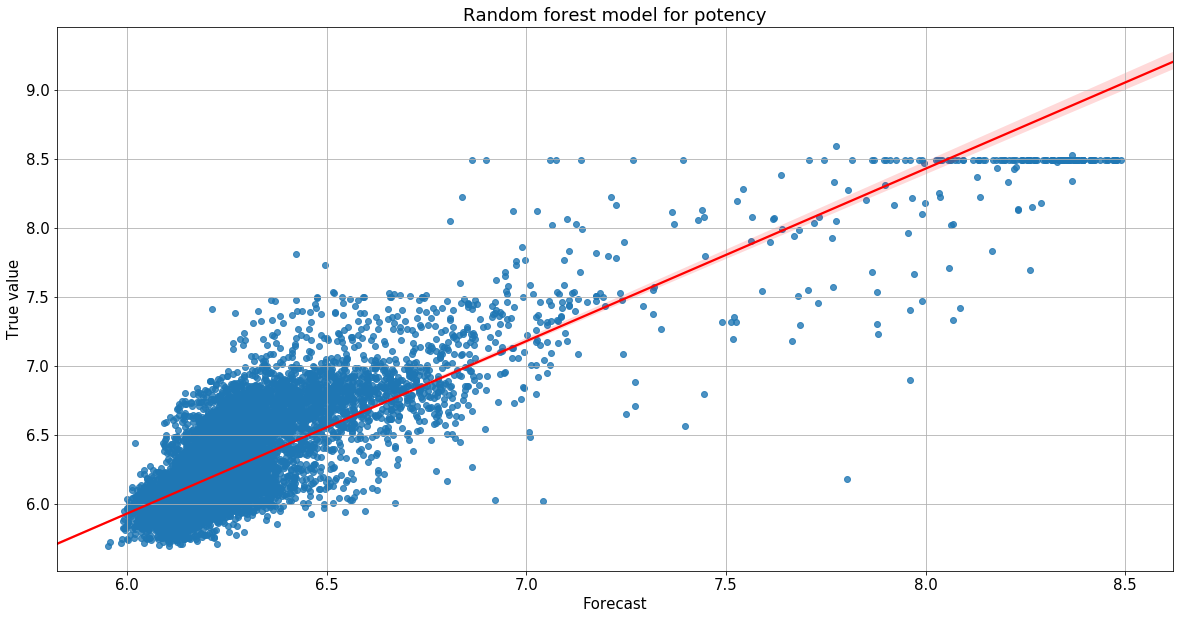

In [24]:
figsize(20, 10)
import seaborn as sns
sns.regplot(x=fc,y=target,fit_reg=True, line_kws={'color' : 'red'})
_ = plt.title('Random forest model for potency')
plt.xlabel('Forecast')
plt.ylabel('True value')
plt.grid(True)

In [25]:
# And we get 70% R^2 (on the whole set!)
stats.regress(target, [fc,])

Coeffs:       1.0000 
R-squared:    0.6995


Now let us look at the performance of our two algorithms, modelling potency, using binary and hashed fingerprints.

The run below, which shows bootstrapped OOS performance of ridge and random forest algorithms, on binary and hashed fingerprints gives us the following results.

- Random forests substantially outperform ridge - and do slightly better on binary fingerprints. 

In [25]:
stats.run_suite(full_df, 'POTENCY')

('Analyzing', 'POTENCY')
Beta:             1.000 [   0.998    1.002] ridge
R2 (signed):      0.185 [   0.156    0.203] at 5pct conf
Beta:             0.998 [   0.997    0.999] rf
R2 (signed):      0.430 [   0.381    0.475] at 5pct conf

Hashed...
Beta:             1.000 [   0.998    1.002] ridge
R2 (signed):      0.178 [   0.146    0.198] at 5pct conf
Beta:             1.000 [   0.998    1.002] rf
R2 (signed):      0.409 [   0.371    0.445] at 5pct conf




We now analyze toxicity models using the TCAMS data.  Again we find that random forests substantially outperform ridge - and this time using hashed fingerprints is slightly better.  The main result though is that adding logP as a predictor improves the model (extra 2% of R2).  This isn't the case for adding QED as a predictor (not shown).

In [26]:
# Add all the data to the Tcams no dups...
#df_tcams_nd = df_tcams.groupby('SMILESIS').mean()
#fps = [get_fp(x, hashed=True) for x in df_tcams_nd.index]
#df_tcams_nd['fps'] = pd.Series([np.asarray(fp).astype(bool) for fp in fps], index=df_tcams_nd.index)
#hfps = [get_fp(x, hashed=True) for x in df_tcams_nd.index]
#df_tcams_nd['hfps'] = pd.Series([np.asarray(fp) for fp in hfps], index=df_tcams_nd.index)
#crippen = pd.Series([utils.get_crippen(Chem.MolFromSmiles(x)) for x in df_tcams_nd.index], index=df_tcams_nd.index)
#qed = pd.Series([utils.get_qed(Chem.MolFromSmiles(x)) for x in df_tcams_nd.index], index=df_tcams_nd.index)
#df_tcams_nd['crippen'] = crippen
#df_tcams_nd['qed'] = qed
#df_tcams_nd.to_pickle('parsed/tcams_nodups.pkl')
#df_tcams_nd = pd.read_pickle('parsed/tcams_nodups.pkl')

In [27]:
stats.run_suite(full_df, 'PCT_INHIB_HEPG2')

('Analyzing', 'PCT_INHIB_HEPG2')
Beta:             0.986 [   0.961    1.027] ridge
R2 (signed):      0.123 [   0.108    0.141] at 5pct conf
Beta:             1.023 [   0.998    1.051] rf
R2 (signed):      0.299 [   0.283    0.314] at 5pct conf

Hashed...
Beta:             0.990 [   0.959    1.016] ridge
R2 (signed):      0.187 [   0.173    0.207] at 5pct conf
Beta:             1.030 [   1.004    1.054] rf
R2 (signed):      0.317 [   0.298    0.333] at 5pct conf




... and if we add an extra predictor of logP

In [28]:
stats.run_suite(full_df, 'PCT_INHIB_HEPG2', add_pred=df_tcams_nd.crippen.values[:,None])

('Analyzing', 'PCT_INHIB_HEPG2')
Beta:             0.985 [   0.952    1.011] ridge
R2 (signed):      0.156 [   0.141    0.171] at 5pct conf
Beta:             1.008 [   0.985    1.034] rf
R2 (signed):      0.322 [   0.308    0.334] at 5pct conf

Hashed...
Beta:             0.986 [   0.961    1.013] ridge
R2 (signed):      0.189 [   0.177    0.200] at 5pct conf
Beta:             1.030 [   1.007    1.054] rf
R2 (signed):      0.335 [   0.315    0.354] at 5pct conf




## Tanimoto distance.

Now, we going to compute the sample standard deviations as a function of Tanimoto distance.  We'll start with the easiest one - 0...

So we're going to have a bunch of samples of different sizes.  The global estimate of the standard deviation is the weighted mean of the different sample estimates, weighted by the sample size

In [26]:
full_df.dropna(subset=['POTENCY'], inplace=True)
fpa = np.asarray([x for x in full_df.fps.values])

fpa = np.asarray([x for x in full_df.fps.values])

estimates = []
weights = []

for i in range(full_df.shape[0]):
    v = [full_df.POTENCY.values[i]]
    dists = cdist(np.asarray([full_df.fps.values[i],]), fpa)[0]
    dists[i]+=1
    gpot = full_df.POTENCY.values[dists == 0]
    if len(gpot) == 0:
        continue
    gpot = np.concatenate((v, gpot))
    estimates.append(np.std(gpot, ddof=1))
    weights.append(gpot.shape[0]-1)
    pass

print('Standard deviation of potency values in our dataset')
print(np.std(full_df.POTENCY.values, ddof=1))
print('Standard deviation of compounds with identical fingerprints')
print(np.average(estimates, weights=weights))
print('Fraction of variance thus explained by fingerprints...')
1-np.average(estimates, weights=weights)**2/np.std(full_df.POTENCY.values, ddof=1)**2

Standard deviation of potency values in our dataset
0.403550341721
Standard deviation of compounds with identical fingerprints
0.143941735166
Fraction of variance thus explained by fingerprints...


0.87277336858678545

OK - so this is a really important result.  The standard deviation of the potency values for malaria of two compounds with identical 128-bit fingerprints is 0.185 (and we have 665 effective datapoints for this estimate, accounting for double-counting).  This means that the 128-bit fingerprint captures 84% of the variance in potency (which is decent!)

What we actually want here is a plot showing the sensitivity of sigma to Tanimoto distance.  So let's construct that (and for toxicity, and plot them (and thus create figure 2 of the paper).


First though - let's just show some examples for the reader of a couple of compounds that are different (and have different potency/toxicity values, but the same fingerprints, and also a couple of compounds that have opposite fingerprints...

In [27]:
from sklearn.metrics.pairwise import pairwise_distances
sum_fp = pd.Series([sum(x) for x in full_df.fps], index=full_df.index)
full_df['good_fp'] = sum_fp
full_dfg = full_df.loc[full_df['good_fp'] >0]
v  = (pairwise_distances(np.asarray([x for x in full_dfg.fps.values]), metric='jaccard') == 0).nonzero()
diffs = np.asarray([full_dfg.iloc[v[0][x]].POTENCY - full_dfg.iloc[v[1][x]].POTENCY for x in range(len(v[0]))])
b = np.argsort(np.abs(diffs))[-10]
a = [v[0][b], v[1][b]]
labels = ['Potency %.2f' % (full_dfg.iloc[x].POTENCY) for x in a]

In [28]:
opposites  = (pairwise_distances(np.asarray([x for x in full_dfg.fps.values]), metric='jaccard') == 1).nonzero()
ao = [opposites[0][0], opposites[1][0]]
olabels = ['Potency %.2f' % (full_dfg.iloc[x].POTENCY) for x in ao]

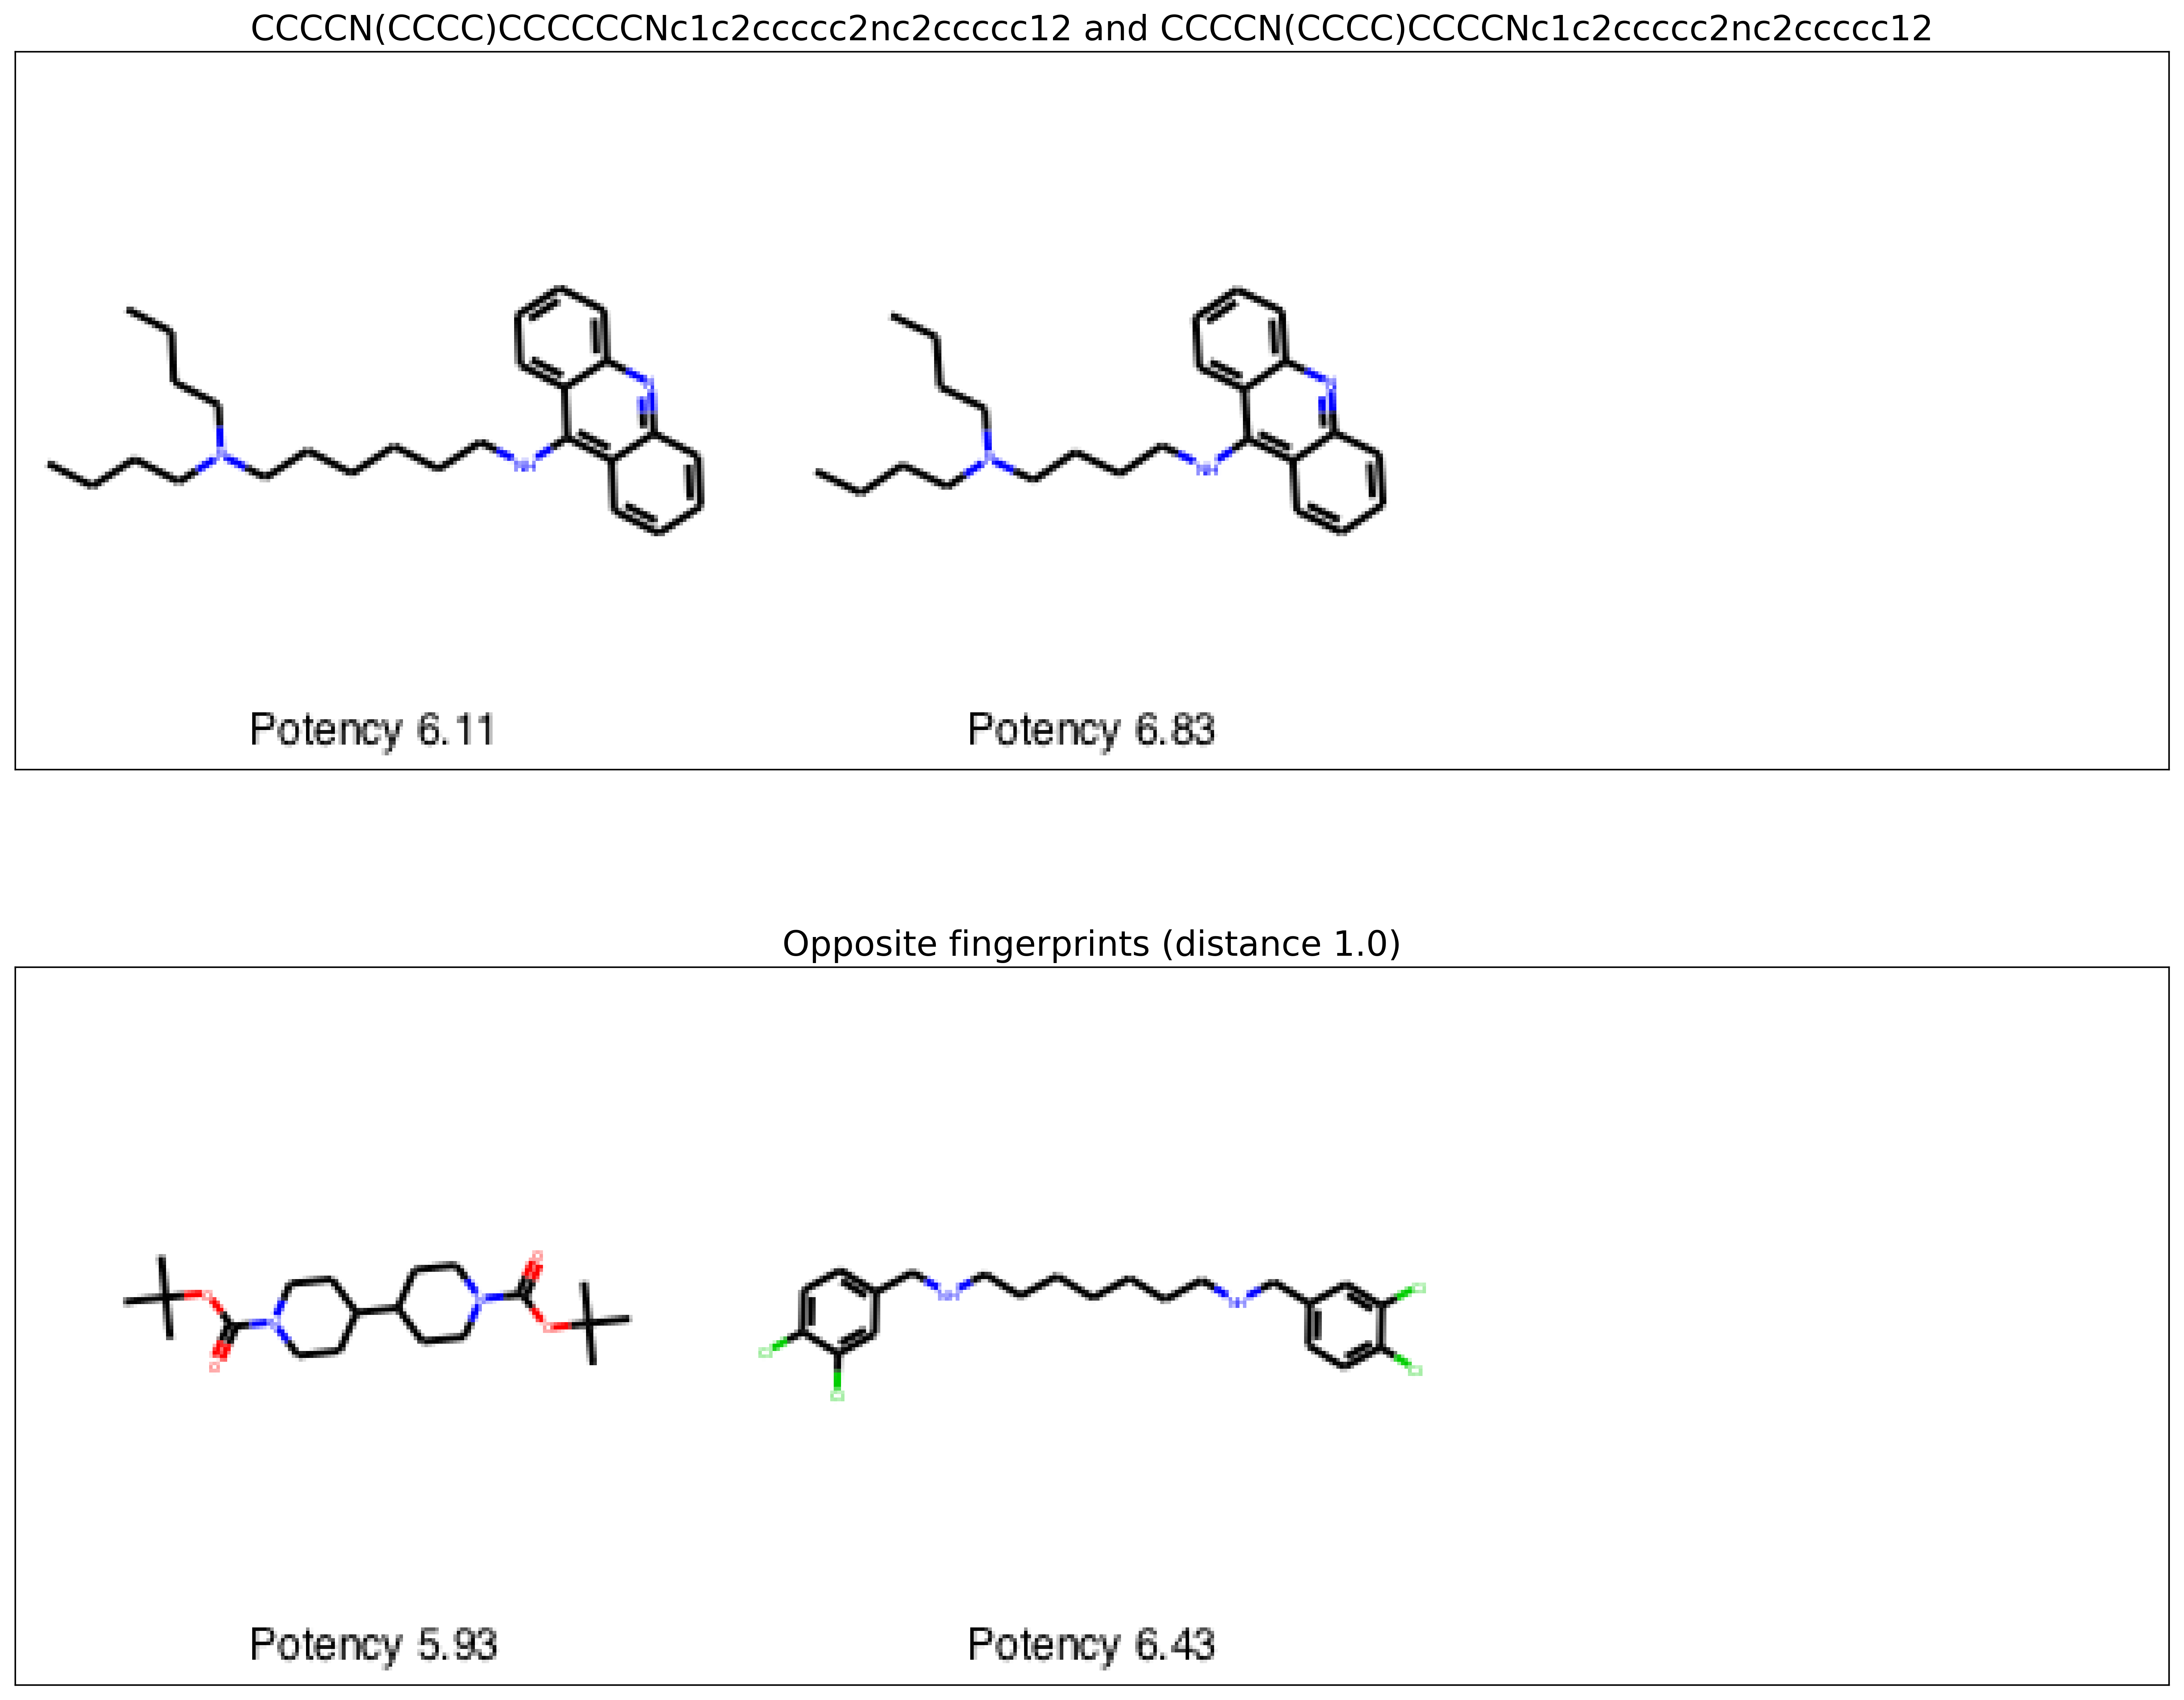

In [32]:
my_smiles = [full_dfg.index[x] for x in [v[0][b], v[1][b]]]
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 16), dpi=400)
plt.subplot(211)
fig = Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(full_dfg.index[x]) for x in a], 
                          legends=labels)
plt.imshow(fig)
plt.xticks([])
plt.yticks([])
_ = plt.title('%s and %s' % tuple(my_smiles))
plt.subplot(212)
fig = Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(full_dfg.index[x]) for x in ao], 
                          legends=olabels)
plt.imshow(fig)
plt.xticks([])
plt.yticks([])
_ = plt.title('Opposite fingerprints (distance 1.0)')
savefig('figures/fig2_same_and_opposite.png')

### Figure 2.

In [59]:
from scipy.spatial.distance import squareform
bins = [-0.001, 0.0001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
cd = cdist(fpa, fpa, metric='jaccard')
cd[np.eye(full_df.shape[0]) == 1] = 2  # 2 > max jaccard distance...
cd[np.isnan(cd)] = 2
dfv = (full_df.POTENCY.values[:,None]-full_df.POTENCY.values[None,:])
ctr_hdr = []
val_hdr = []
for i in range(1, len(bins)):
    s_bin = bins[i-1]
    e_bin = bins[i]
    std_val = np.std(dfv[(cd > s_bin) & (cd <= e_bin)])
    val_hdr.append(std_val)
    ctr_hdr.append(np.mean(cd[(cd > s_bin) & (cd <= e_bin)]))

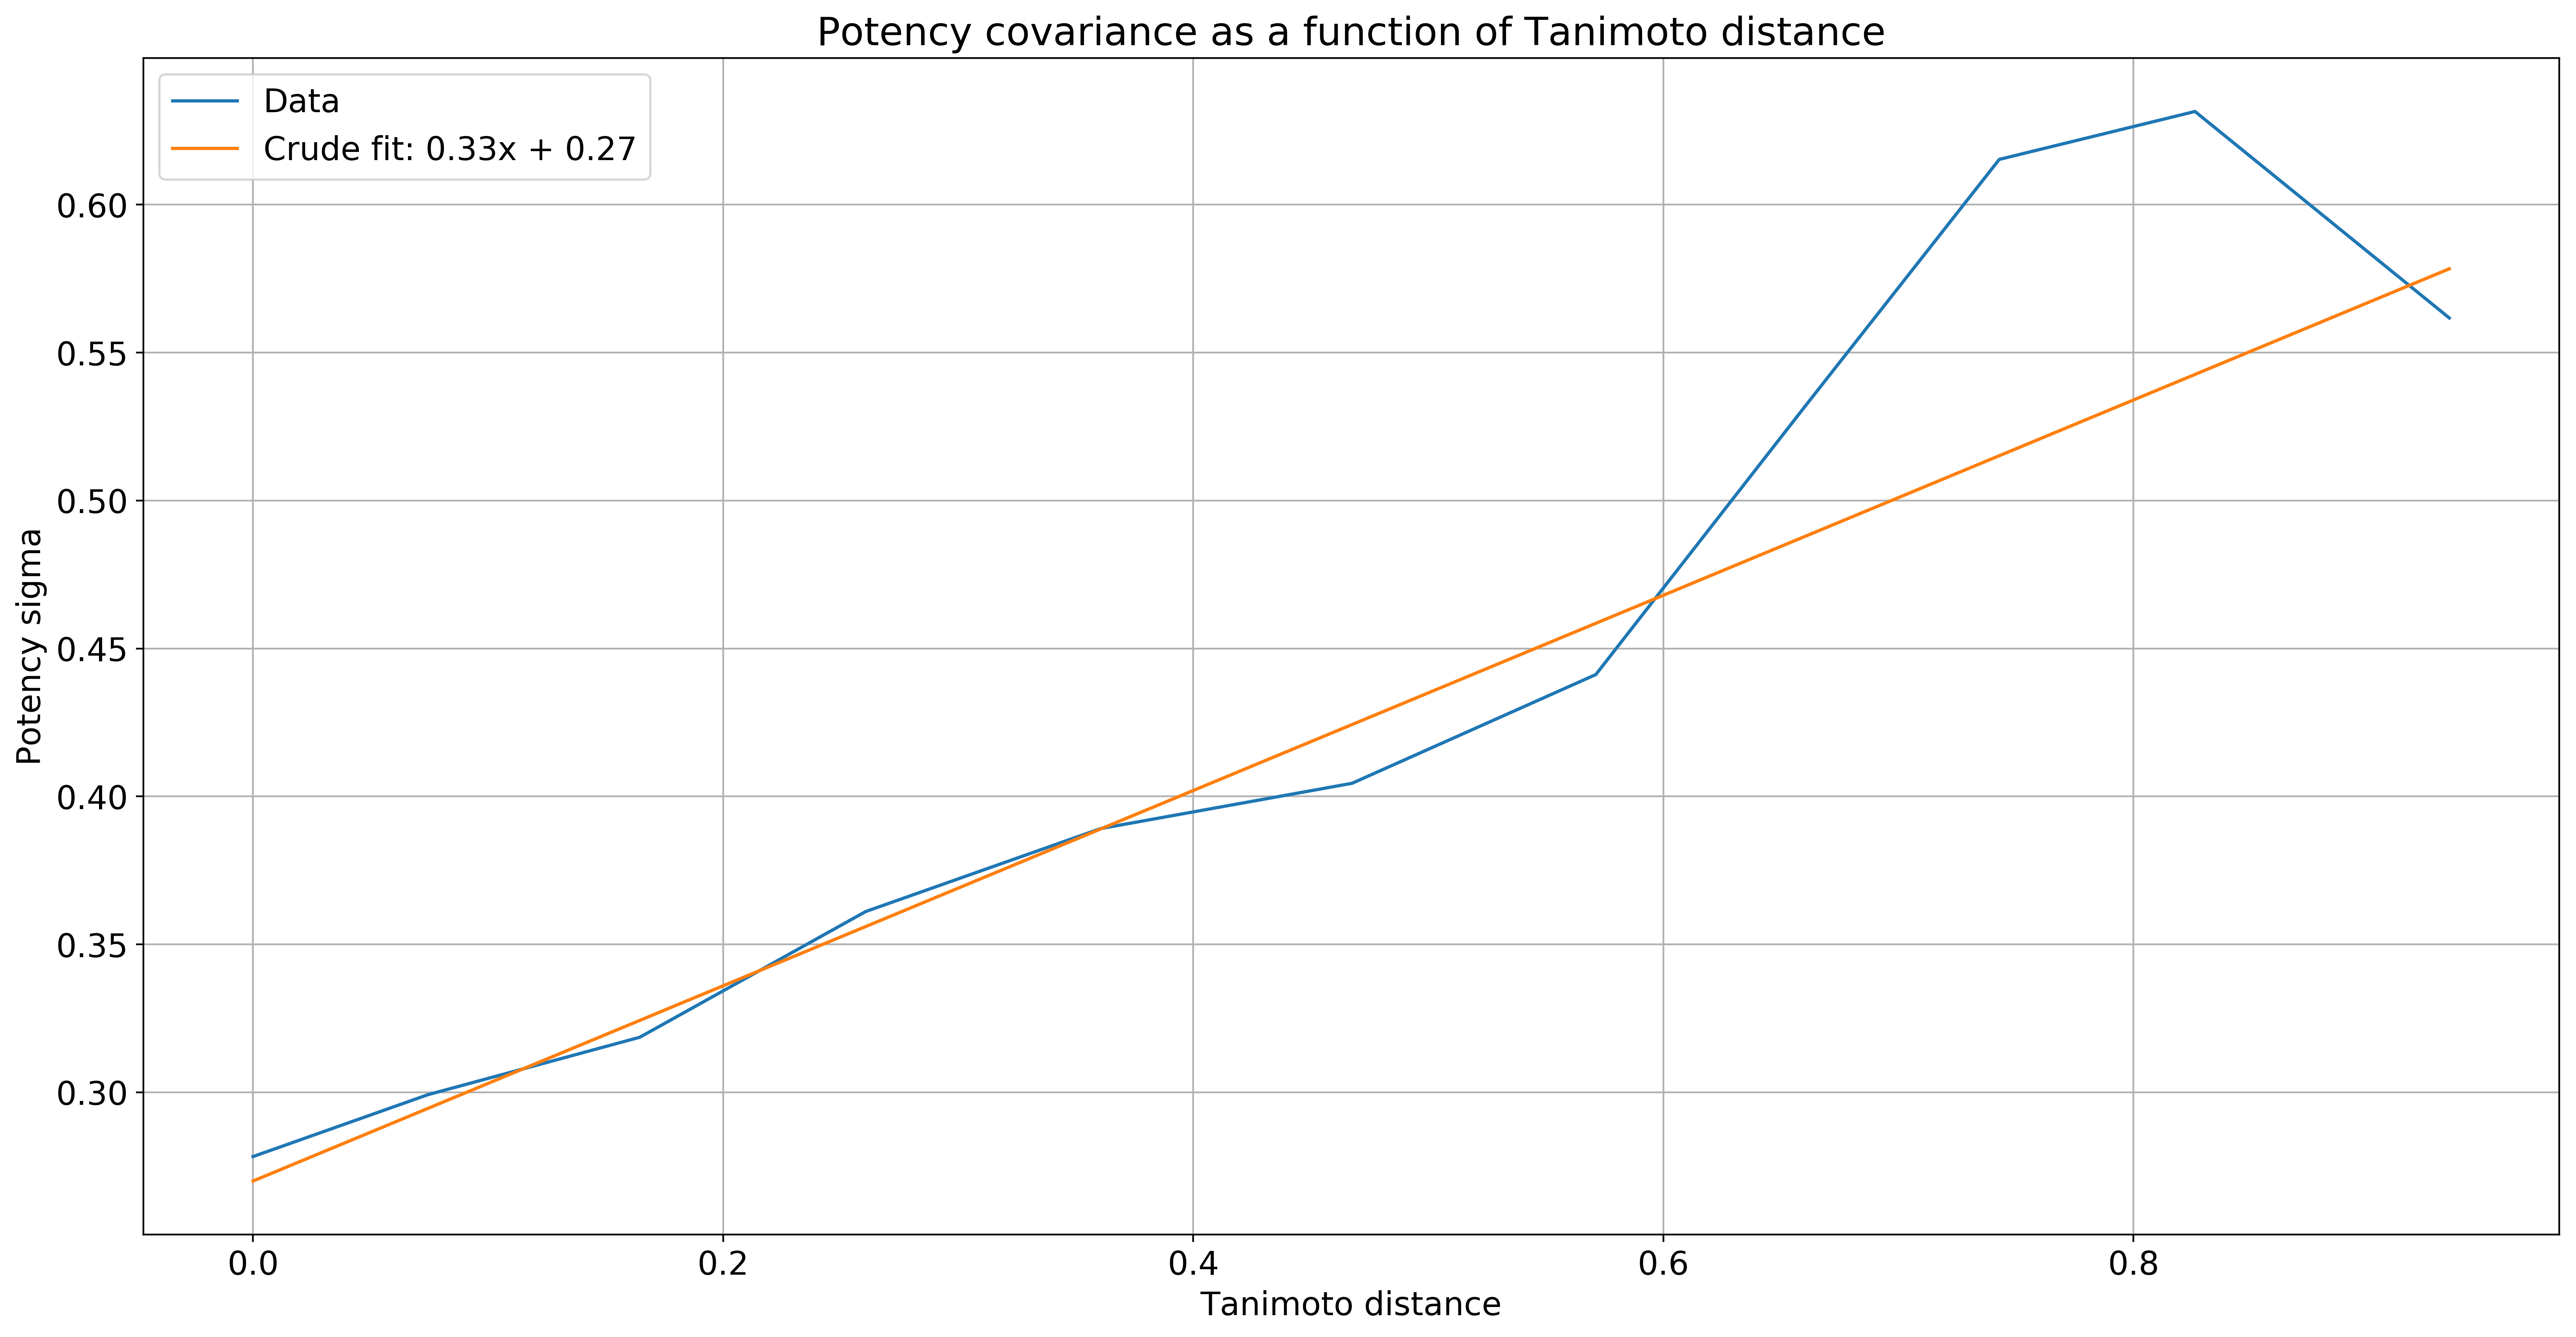

In [62]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 10), dpi=400)
plt.plot(ctr_hdr, val_hdr, label='Data'); grid(True); xlabel('Tanimoto distance'); ylabel('Potency sigma')
plt.plot(ctr_hdr, 0.27+0.33*np.asarray(ctr_hdr), label='Crude fit: 0.33x + 0.27');
legend(loc='best')
_ = title('Potency covariance as a function of Tanimoto distance')

So now we understand how covariance works as a function of Tanimoto distance - let's see how our models perform when they are restricted to fitting on points above some minimum Tanimoto distance from the target point...

In [63]:
fc_rf_hdr = {}
fc_lr_hdr = {}
ctr_hdr = {}  # this tells you the mean distance...

def rank(x):
    return np.argsort(np.argsort(x))/(len(x) + 0.) - 0.5

bins = [0, 0.1, 0.2, 0.4, 0.6, 0.7, 0.9]

# stats.run_big_fit(full_df.dropna(subset=['POTENCY']))

#joblib.dump(fc_rf_hdr, 'modelling/rf_fc_results')
#joblib.dump(fc_lr_hdr, 'modelling/rdg_fc_results')
#joblib.dump(ctr_hdr, 'modelling/ctr_results')
fc_rf_hdr = joblib.load('modelling/rf_fc_results')
fc_lr_hdr = joblib.load('modelling/rdg_fc_results')
ctr_hdr = joblib.load('modelling/ctr_results')


#result_hdr = {'rf' : [], 'rdg' : [], 'rfrk' : [], 'rdgrk' : [], 
#             'rfb' : [], 'rdgb' : [], 'rfrkb' : [], 'rdgrkb' : [], 
#             }#
#
#for i in range(len(bins)):
#    rf_beta, rf_r2 = stats.regress(full_df.POTENCY.values, [fc_rf_hdr[i],], do_print=False, one=True)
#    rdg_beta, rdg_r2 = stats.regress(full_df.POTENCY.values, [fc_lr_hdr[i],], do_print=False, one=True)
#    rfr_beta, rfr_r2 = stats.regress(rank(full_df.POTENCY.values), [rank(fc_rf_hdr[i]),], 
#                                     do_print=False)
#    rdgr_beta, rdgr_r2 = stats.regress(rank(full_df.POTENCY.values), [rank(fc_lr_hdr[i]),], 
#                                       do_print=False)   
#    
#    result_hdr['rf'].append(rf_r2)
#    result_hdr['rfb'].append(rf_beta[0])
#    result_hdr['rdg'].append(rdg_r2)
#    result_hdr['rdgb'].append(rdg_beta[0])
#    result_hdr['rfrk'].append(rfr_r2)
#    result_hdr['rfrkb'].append(rfr_beta[0])
#    result_hdr['rdgrk'].append(rdgr_r2)
#    result_hdr['rdgrkb'].append(rdgr_beta[0])
       
result_hdr = joblib.load('results/summary_results_tcnd')

### Figure 3.

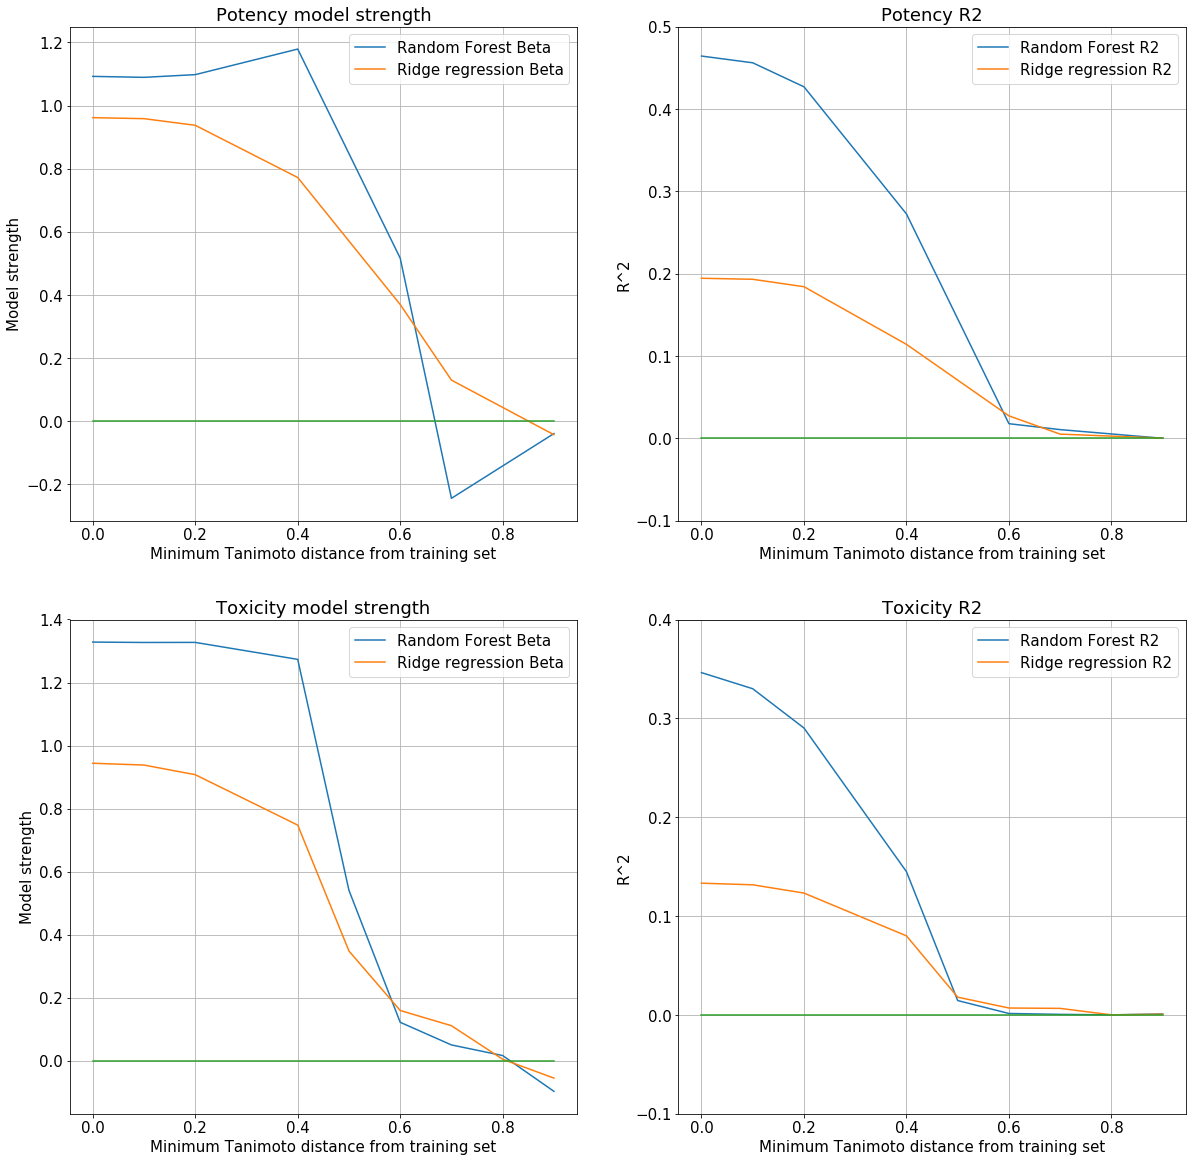

In [64]:
bins = [0, 0.1, 0.2, 0.4, 0.6, 0.7,  0.9]
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20))
plt.subplot(221)
plt.plot(bins, result_hdr['rfb'], label='Random Forest Beta')
plt.plot(bins, result_hdr['rdgb'], label='Ridge regression Beta'); 
plt.plot(bins, np.zeros(len(bins)))
plt.xlabel('Minimum Tanimoto distance from training set')
plt.ylabel('Model strength')
plt.grid(True); plt.legend(loc='best')
plt.title('Potency model strength')
plt.subplot(222)
plt.plot(bins, result_hdr['rf'], label='Random Forest R2')
plt.plot(bins, result_hdr['rdg'], label='Ridge regression R2'); 
plt.plot(bins, np.zeros(len(bins)))
plt.xlabel('Minimum Tanimoto distance from training set')
plt.ylabel('R^2')
plt.ylim((-0.1, 0.5))
plt.grid(True); plt.legend(loc='best')
plt.title('Potency R2')

bins_tox = [0, 0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
result_hdr_tox = joblib.load('results_tox/summary_results')
plt.subplot(223)
plt.plot(bins_tox, result_hdr_tox['rfb'], label='Random Forest Beta')
plt.plot(bins_tox, result_hdr_tox['rdgb'], label='Ridge regression Beta'); 
plt.plot(bins_tox, np.zeros(len(bins_tox)))
plt.xlabel('Minimum Tanimoto distance from training set')
plt.ylabel('Model strength')
plt.grid(True); plt.legend(loc='best')
plt.title('Toxicity model strength')

plt.subplot(224)
plt.plot(bins_tox, result_hdr_tox['rf'], label='Random Forest R2')
plt.plot(bins_tox, result_hdr_tox['rdg'], label='Ridge regression R2'); 
plt.plot(bins_tox, np.zeros(len(bins_tox)))
plt.xlabel('Minimum Tanimoto distance from training set')
plt.ylabel('R^2')
plt.ylim((-0.1, 0.4))
plt.grid(True); plt.legend(loc='best')
_ = plt.title('Toxicity R2')
savefig('figures/fig4_str_r2.png')

## Bias.

Unfortunately we need to deal with the bias in the data - hence we need to work out how to correct for it.  Here we run the analysis described in the paper to perform the bias correction.

In [65]:
tc_dists = cdist(fpa, fpa, metric='jaccard') + np.diag(np.ones(len(fpa)) * np.nan)
import glob
std_files = glob.glob('/Users/oliverwatson/evartech/molport/standardn_*')
df0 = pd.read_pickle(std_files[0])
idcs = np.random.choice(np.arange(df0.shape[0]), 10000)
fpr = np.asarray([x for x in df0.iloc[idcs].fps.values])
r_dists = cdist(fpr, fpr, metric='jaccard') + np.diag(np.ones(len(fpr)) * np.nan)
tcr_dists = cdist(fpr, fpa, metric='jaccard')
mal_hist= np.histogram(tc_dists[~np.isnan(tc_dists)], density=True, bins=7)
mr_hist = np.histogram(tcr_dists[~np.isnan(tcr_dists)], density=True, bins=7)

# magic number - but justified by looking at the bottom plot below.
num_inactive_per_active = 150

In [66]:
N = df0.shape[0]
i = 0
all_dists = np.asarray([])

while (i < N - 1):
    idcs = np.arange(i, min(N, i+10000))
    fpr = np.asarray([x for x in df0.iloc[idcs].fps.values])
    blk_dists = nanmin(cdist(fpr, fpa, metric='jaccard'),axis=1)
    all_dists = np.concatenate((blk_dists, all_dists))
    i += 10000



In [67]:
2e6/13533

147.78689130274145

### Figure 4.

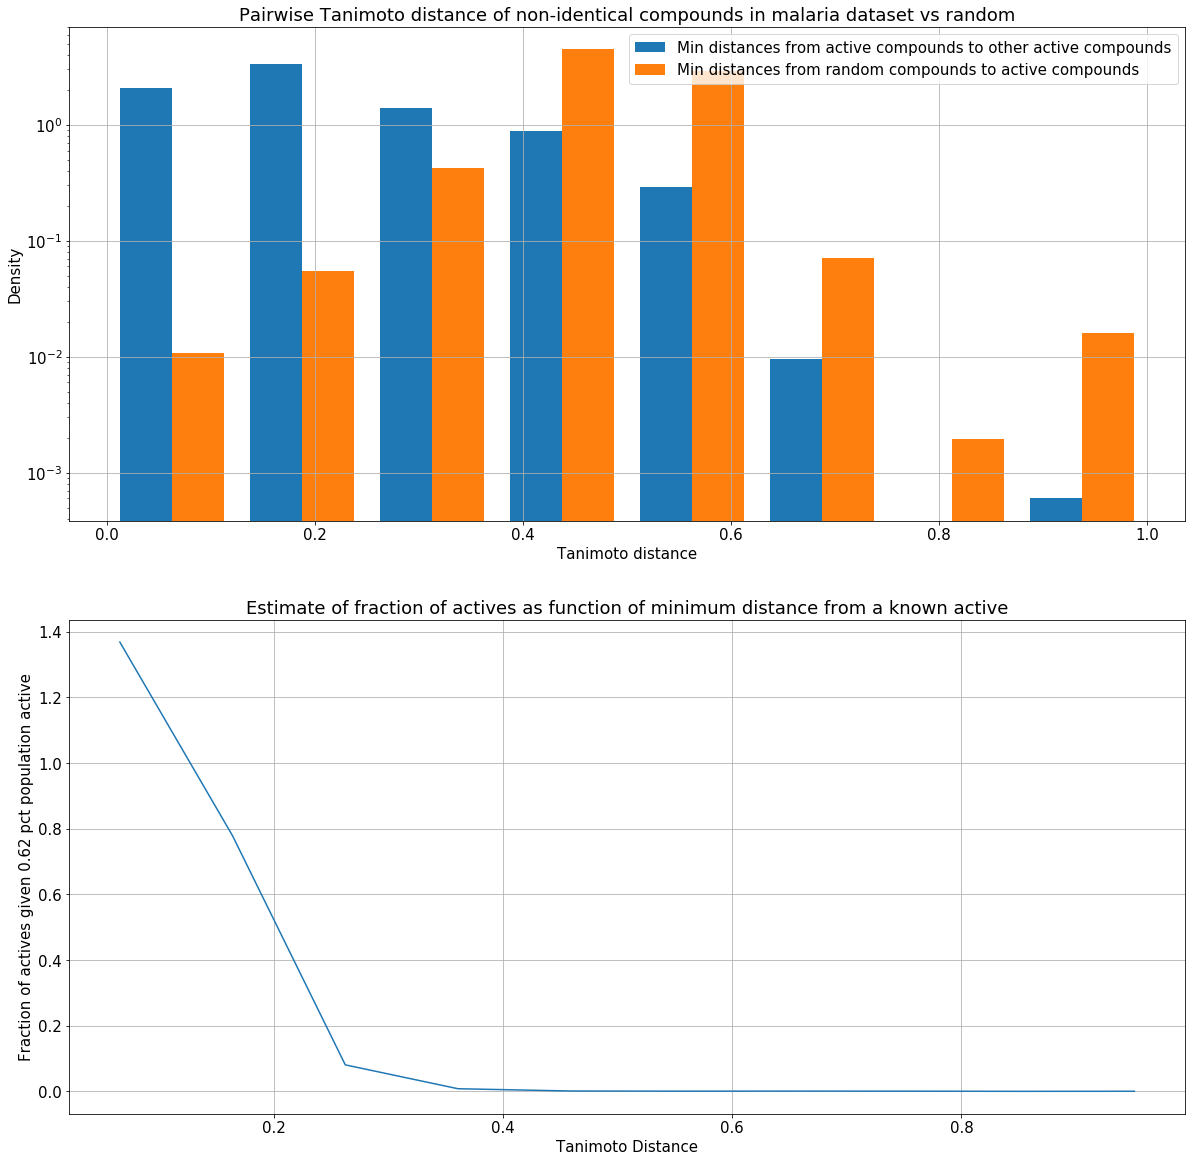

In [69]:
import glob
num_inactive_per_active = 2.2e6/13533
std_files = glob.glob('/Users/oliverwatson/evartech/molport/standardn_*')
df0 = pd.read_pickle(std_files[0])
np.random.seed(42)
idcs = np.random.choice(np.arange(df0.shape[0]), 20000)
fpr = np.asarray([x for x in df0.iloc[idcs].fps.values])
r_dists = cdist(fpr, fpr, metric='jaccard') + np.diag(np.ones(len(fpr)) * np.nan)

cdfpa = cdist(fpa, fpa, metric='jaccard')
cdfpa[cdfpa==0] = np.nan
mtc_dists = nanmin(cdfpa, axis=1)
cdfpa = None
mtcr_dists = nanmin(cdist(fpr, fpa, metric='jaccard'),axis=1)

mal_hist= np.histogram(mtc_dists[~np.isnan(mtc_dists)], density=True, bins=10)
#mr_hist = np.histogram(mtcr_dists[~np.isnan(mtcr_dists)], density=True, bins=10)
mra_hist = np.histogram(all_dists[~np.isnan(all_dists)], density=True, bins=10)
x_axis = 0.5*(mal_hist[1][1:] + mal_hist[1][:-1])
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20))
plt.subplot(211)
plt.hist((mtc_dists[~np.isnan(mtc_dists)],all_dists[~np.isnan(all_dists)]), 
         bins=8, density=True, label=('Min distances from active compounds to other active compounds', 
                                       'Min distances from random compounds to active compounds'))
plt.yscale('log')
plt.xlabel('Tanimoto distance')
plt.ylabel('Density')
plt.grid('True')
plt.legend(loc='best')
plt.title('Pairwise Tanimoto distance of non-identical compounds in malaria dataset vs random')
plt.subplot(212)
plt.plot(x_axis, mal_hist[0]/(num_inactive_per_active*mra_hist[0]))
plt.grid(True)
plt.xlabel('Tanimoto Distance')
plt.ylabel('Fraction of actives given %.2f pct population active' % (100/num_inactive_per_active))
_ = plt.title('Estimate of fraction of actives as function of minimum distance from a known active')
savefig('figures/fig5_bias_correction.png')

# Using our models

Now we can actually create a proper extrapolative model to use in predicting on general compounds...

In [91]:
from functools import partial
frac_active = partial(np.interp, xp=x_axis, fp=(mal_hist[0]/(num_inactive_per_active*mra_hist[0])).clip(0., 1.))

# magic number - but with some emprical support in the paper...
inactive_level = 3.5
active_level = np.mean(full_df.POTENCY.values)
rf_beta = partial(np.interp, xp=bins, fp=result_hdr['rfb'])

# first fit full models....
reload(stats)
df_tcams_nd = pd.read_pickle('parsed/tcams_nodups.pkl')
full_models = stats.fit_models(df_tcams_nd, full_df)
from malaria import mp_utils

full_models['rfb'] = rf_beta
full_models['frac_act'] = frac_active
full_models['inactive_level'] = inactive_level
full_models['active_level'] = active_level

In [92]:
x_axis

array([ 0.06583333,  0.16416667,  0.2625    ,  0.36083333,  0.45916667,
        0.5575    ,  0.65583333,  0.75416667,  0.8525    ,  0.95083333])

In [93]:
(mal_hist[0]/(0.1 + num_inactive_per_active*mr_hist[0]))

ValueError: operands could not be broadcast together with shapes (10,) (7,) 

In [94]:
# Adding minimum distance from training set data to the Molport data...
from malaria import mp_utils

#min_dist = np.ones(mp1.shape[0])
#mp1 = pd.read_pickle(std_files[0])
#mp1_fps = np.asarray([x for x in mp1.fps.values])
blk = []
smile_blk = []

def make_blocks():
    for i in range(1, full_df.shape[0], 1000):
        e = min(i+1000, full_df.shape)
        blk.append(np.asarray([x for x in full_df.fps.values[i:e]]))
        smile_blk.append([x for x in full_df.index[i:e]])
        pass

#make_blocks()

def add_min_dist(fn):
    mp_df = pd.read_pickle(fn)
    
    mins = np.ones(mp_df.shape[0], dtype=float)
    amins = np.ones(mp_df.shape[0], dtype=float)
    min_smiles = mp_df.SMILESIS.values.copy()
    mp1_fps = np.asarray([x for x in mp_df.fps.values])
    
    for (i, bl) in enumerate(blk):
        bl_min = np.min(cdist(bl, mp1_fps, metric='jaccard'), axis=0)
        amin = np.argmin(cdist(bl, mp1_fps, metric='jaccard'), axis=0)
        
        min_smiles[bl_min < mins] = np.asarray(smile_blk[i])[amin[bl_min < mins]]
        mins = np.minimum(mins, bl_min)
    
    md = pd.Series(mins, index=mp_df.index)
    sm = pd.Series(min_smiles, index=mp_df.index)
    mp_df['min_dist'] = md
    mp_df['min_smile'] = sm
    mp_df.to_pickle(fn)
    
#for fn in std_files:
#    add_min_dist(fn)    

In [95]:
#reload(mp_utils)
#mp_utils.get_best(full_models, drugs=drugs)

Now choose the top compounds from Molport accoriding to various criteria...

### Figure 5.

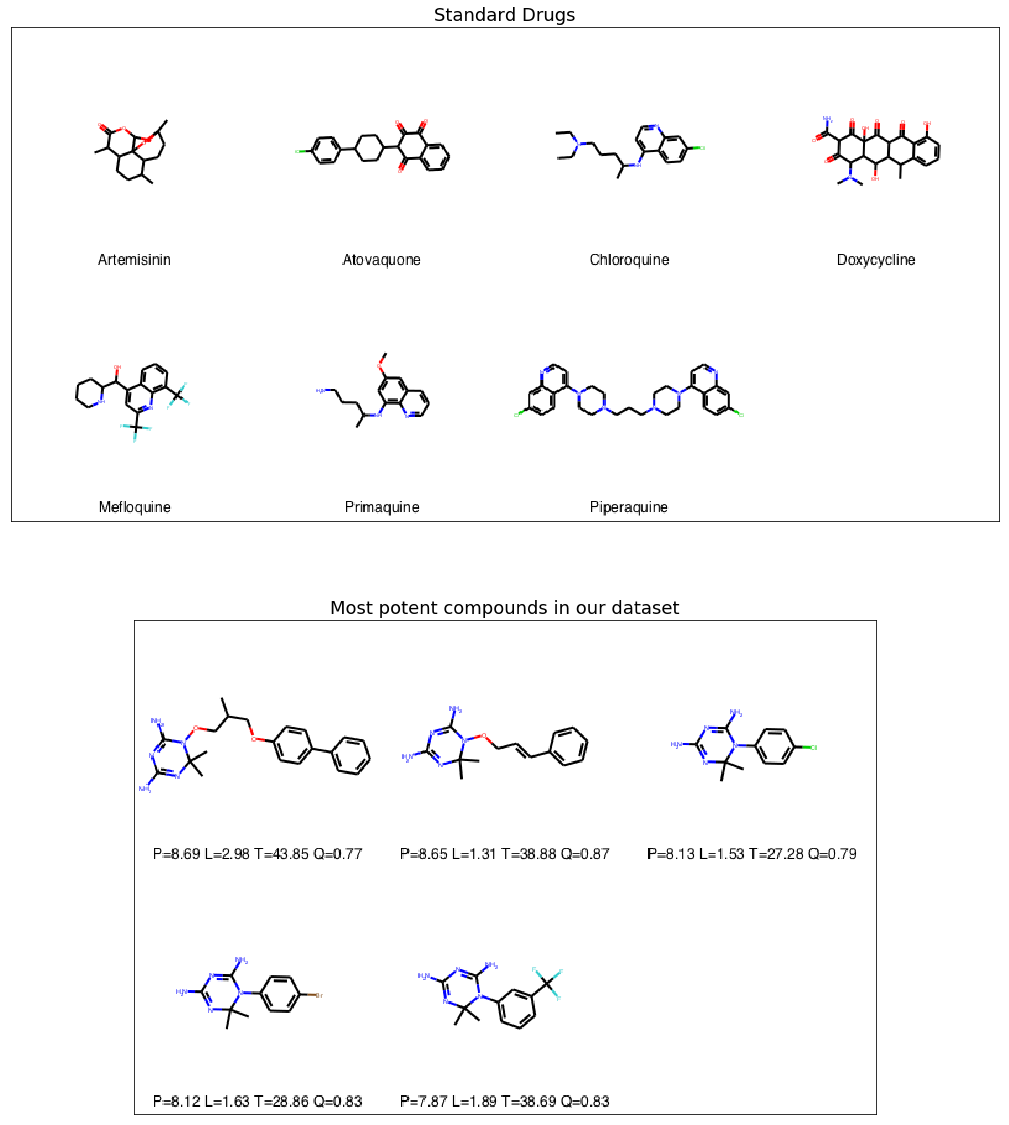

In [96]:
Artemisinin = 'CC1CCC2C(C(=O)OC3C24C1CCC(O3)(OO4)C)C'
Atovaquone  = 'C1CC(CCC1C2=CC=C(C=C2)Cl)C3=C(C4=CC=CC=C4C(=O)C3=O)O'
Chloroquine = 'CCN(CC)CCCC(C)NC1=C2C=CC(=CC2=NC=C1)Cl'
Doxycycline = 'CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4O)O)O)O)C(=O)N)N(C)C)O'
Mefloquine  = 'C1CCNC(C1)C(C2=CC(=NC3=C2C=CC=C3C(F)(F)F)C(F)(F)F)O'
Primaquine  = 'CC(CCCN)NC1=C2C(=CC(=C1)OC)C=CC=N2'
Piperaquine = 'C1CN(CCN1CCCN2CCN(CC2)C3=C4C=CC(=CC4=NC=C3)Cl)C5=C6C=CC(=CC6=NC=C5)Cl'
drugs = [Artemisinin, Atovaquone, Chloroquine, Doxycycline, Mefloquine, Primaquine, Piperaquine]
drugs = [standardise.run(drug) for drug in drugs]
drug_labels = ['Artemisinin', 'Atovaquone', 'Chloroquine', 
               'Doxycycline', 'Mefloquine', 'Primaquine', 'Piperaquine']

# Figure pot_hist in the paper.
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20))
plt.subplot(211)
fig = Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in drugs], 
                          legends=drug_labels, molsPerRow=4)
plt.imshow(fig)
plt.xticks([])
plt.yticks([])
plt.title('Standard Drugs')
plt.subplot(212)
fig = mp_utils.summarize('POT', 5)
plt.imshow(fig)
plt.xticks([])
plt.yticks([])
_ = plt.title('Most potent compounds in our dataset')
savefig('figures/fig6_drugs_n_pot.png')

### Figure 7.

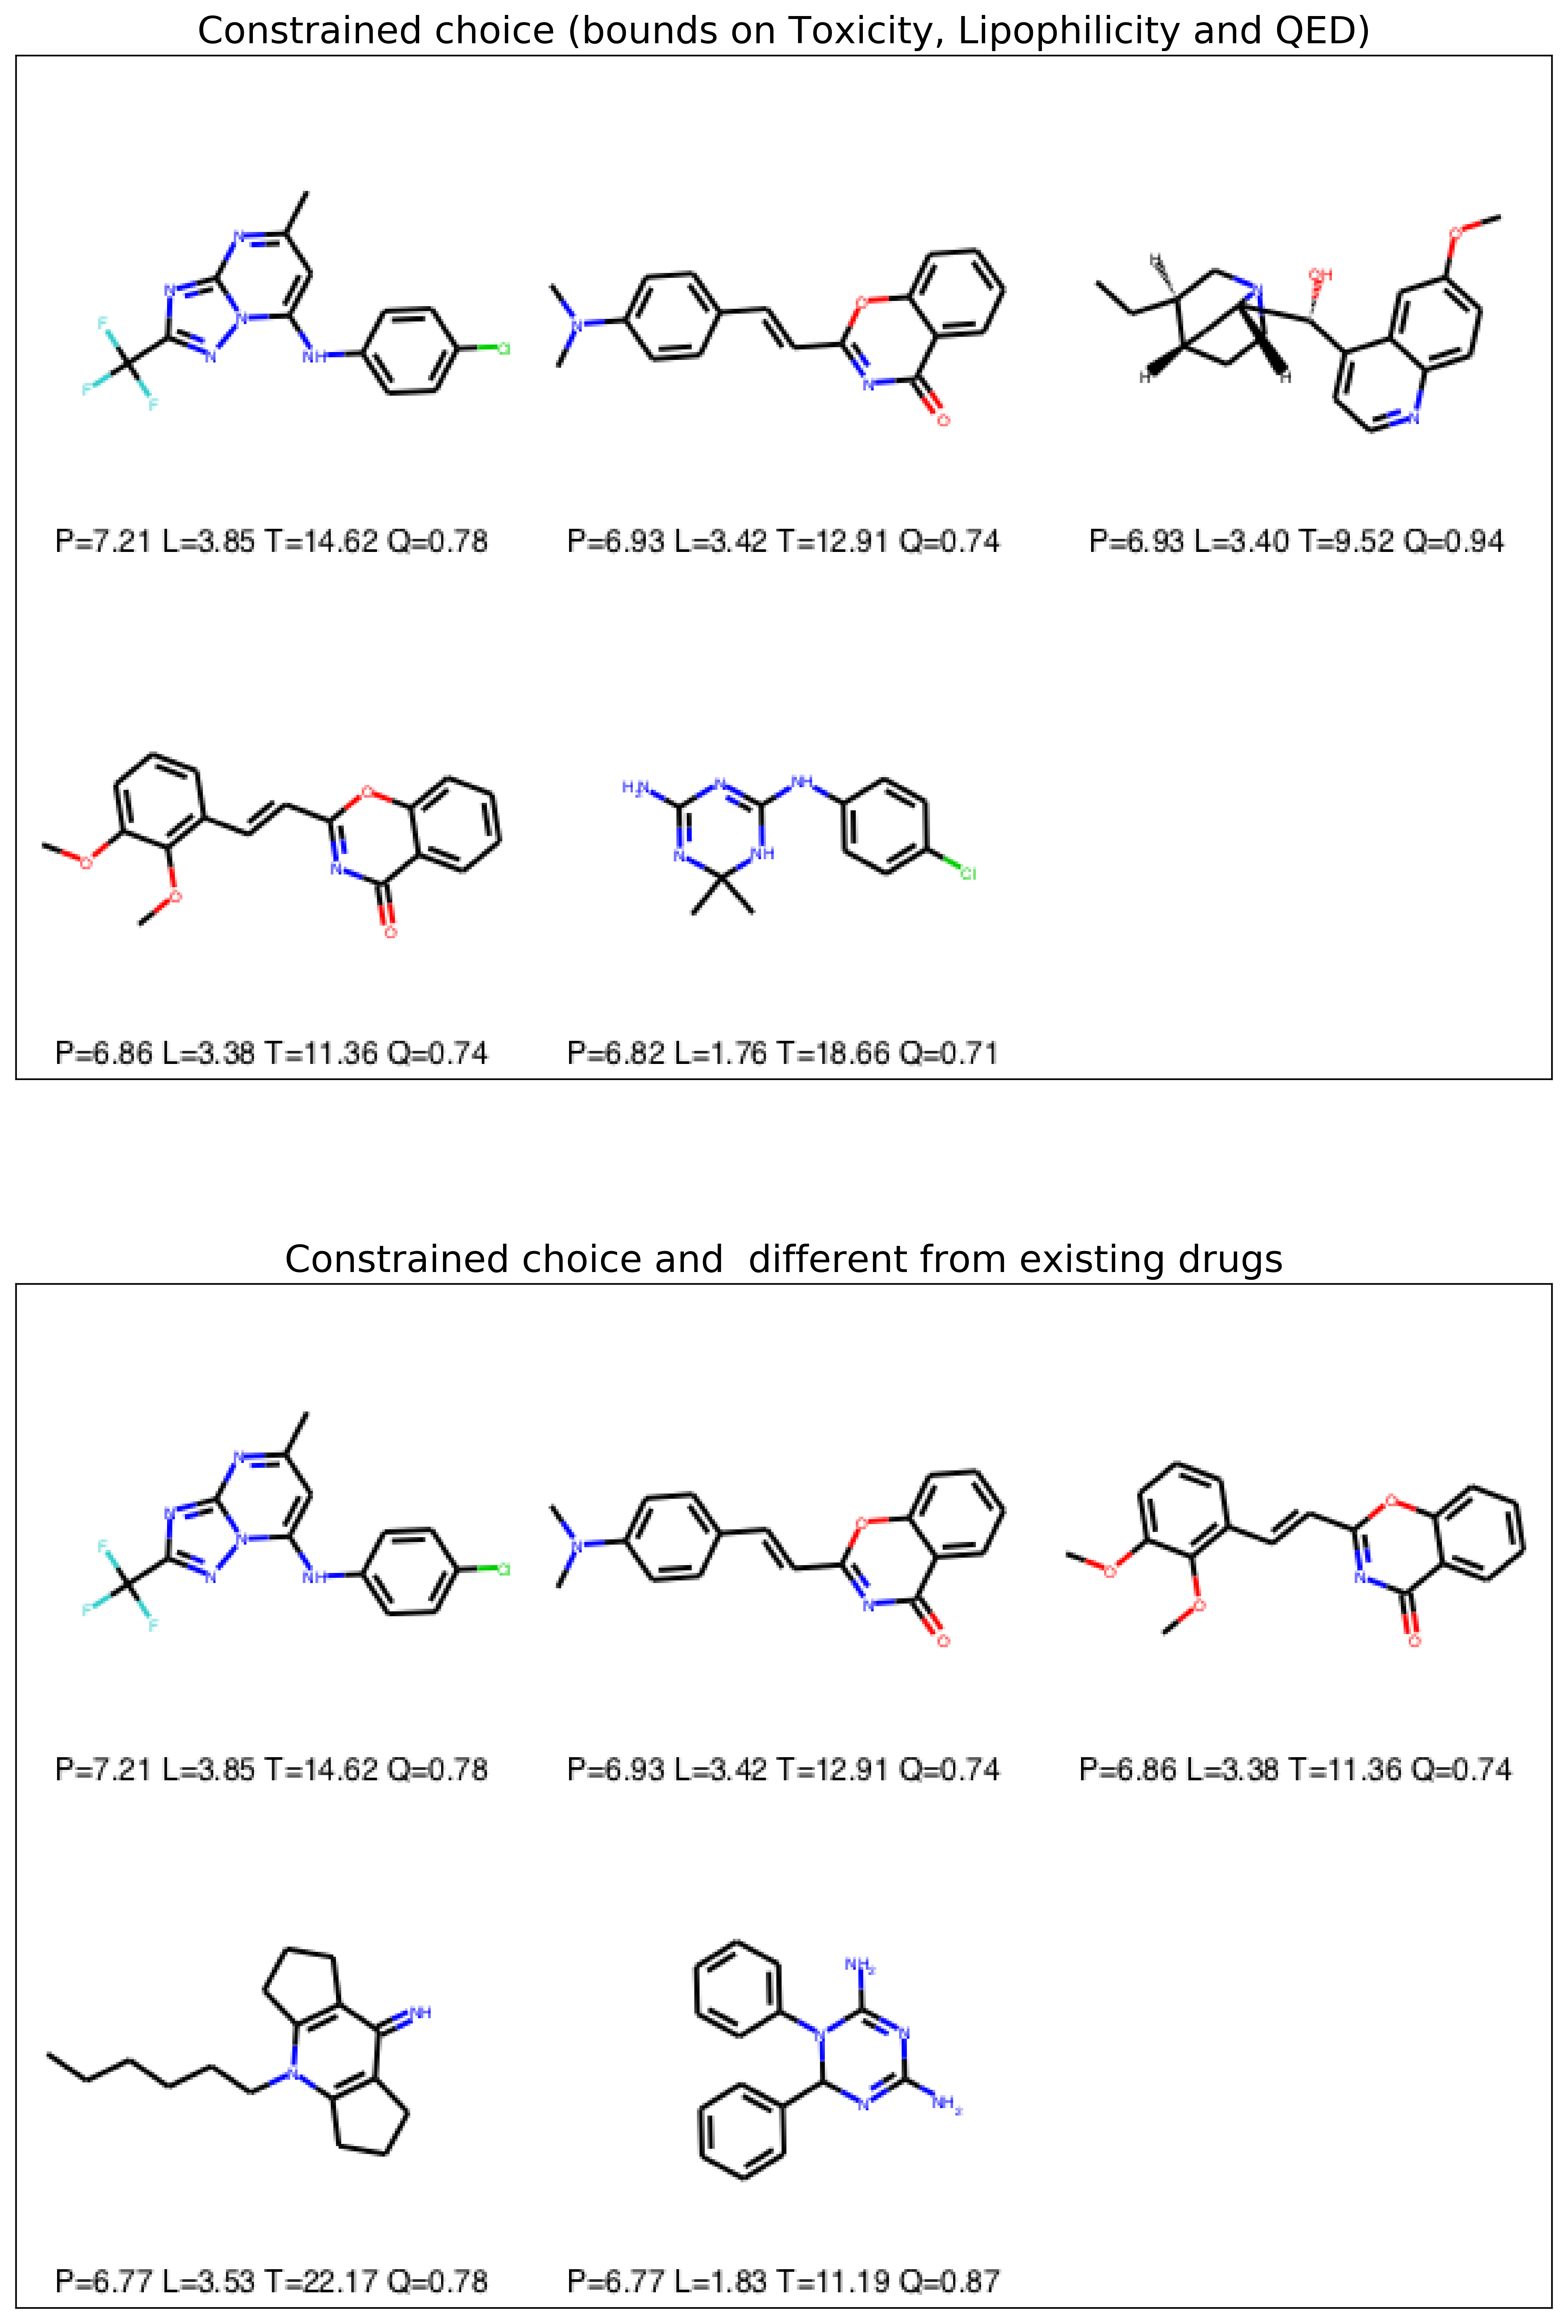

In [97]:
# Figure pot_hist in the paper.
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20), dpi=400)
plt.subplot(211)
fig = mp_utils.summarize('BEST_Q', 5)
plt.imshow(fig)
plt.xticks([])
plt.yticks([])
plt.title('Constrained choice (bounds on Toxicity, Lipophilicity and QED)')
plt.subplot(212)
fig = mp_utils.summarize('BEST_D', 5)
plt.imshow(fig)
plt.xticks([])
plt.yticks([])
_ = plt.title('Constrained choice and  different from existing drugs')
savefig('figures/fig7.png')

### Figure 8.

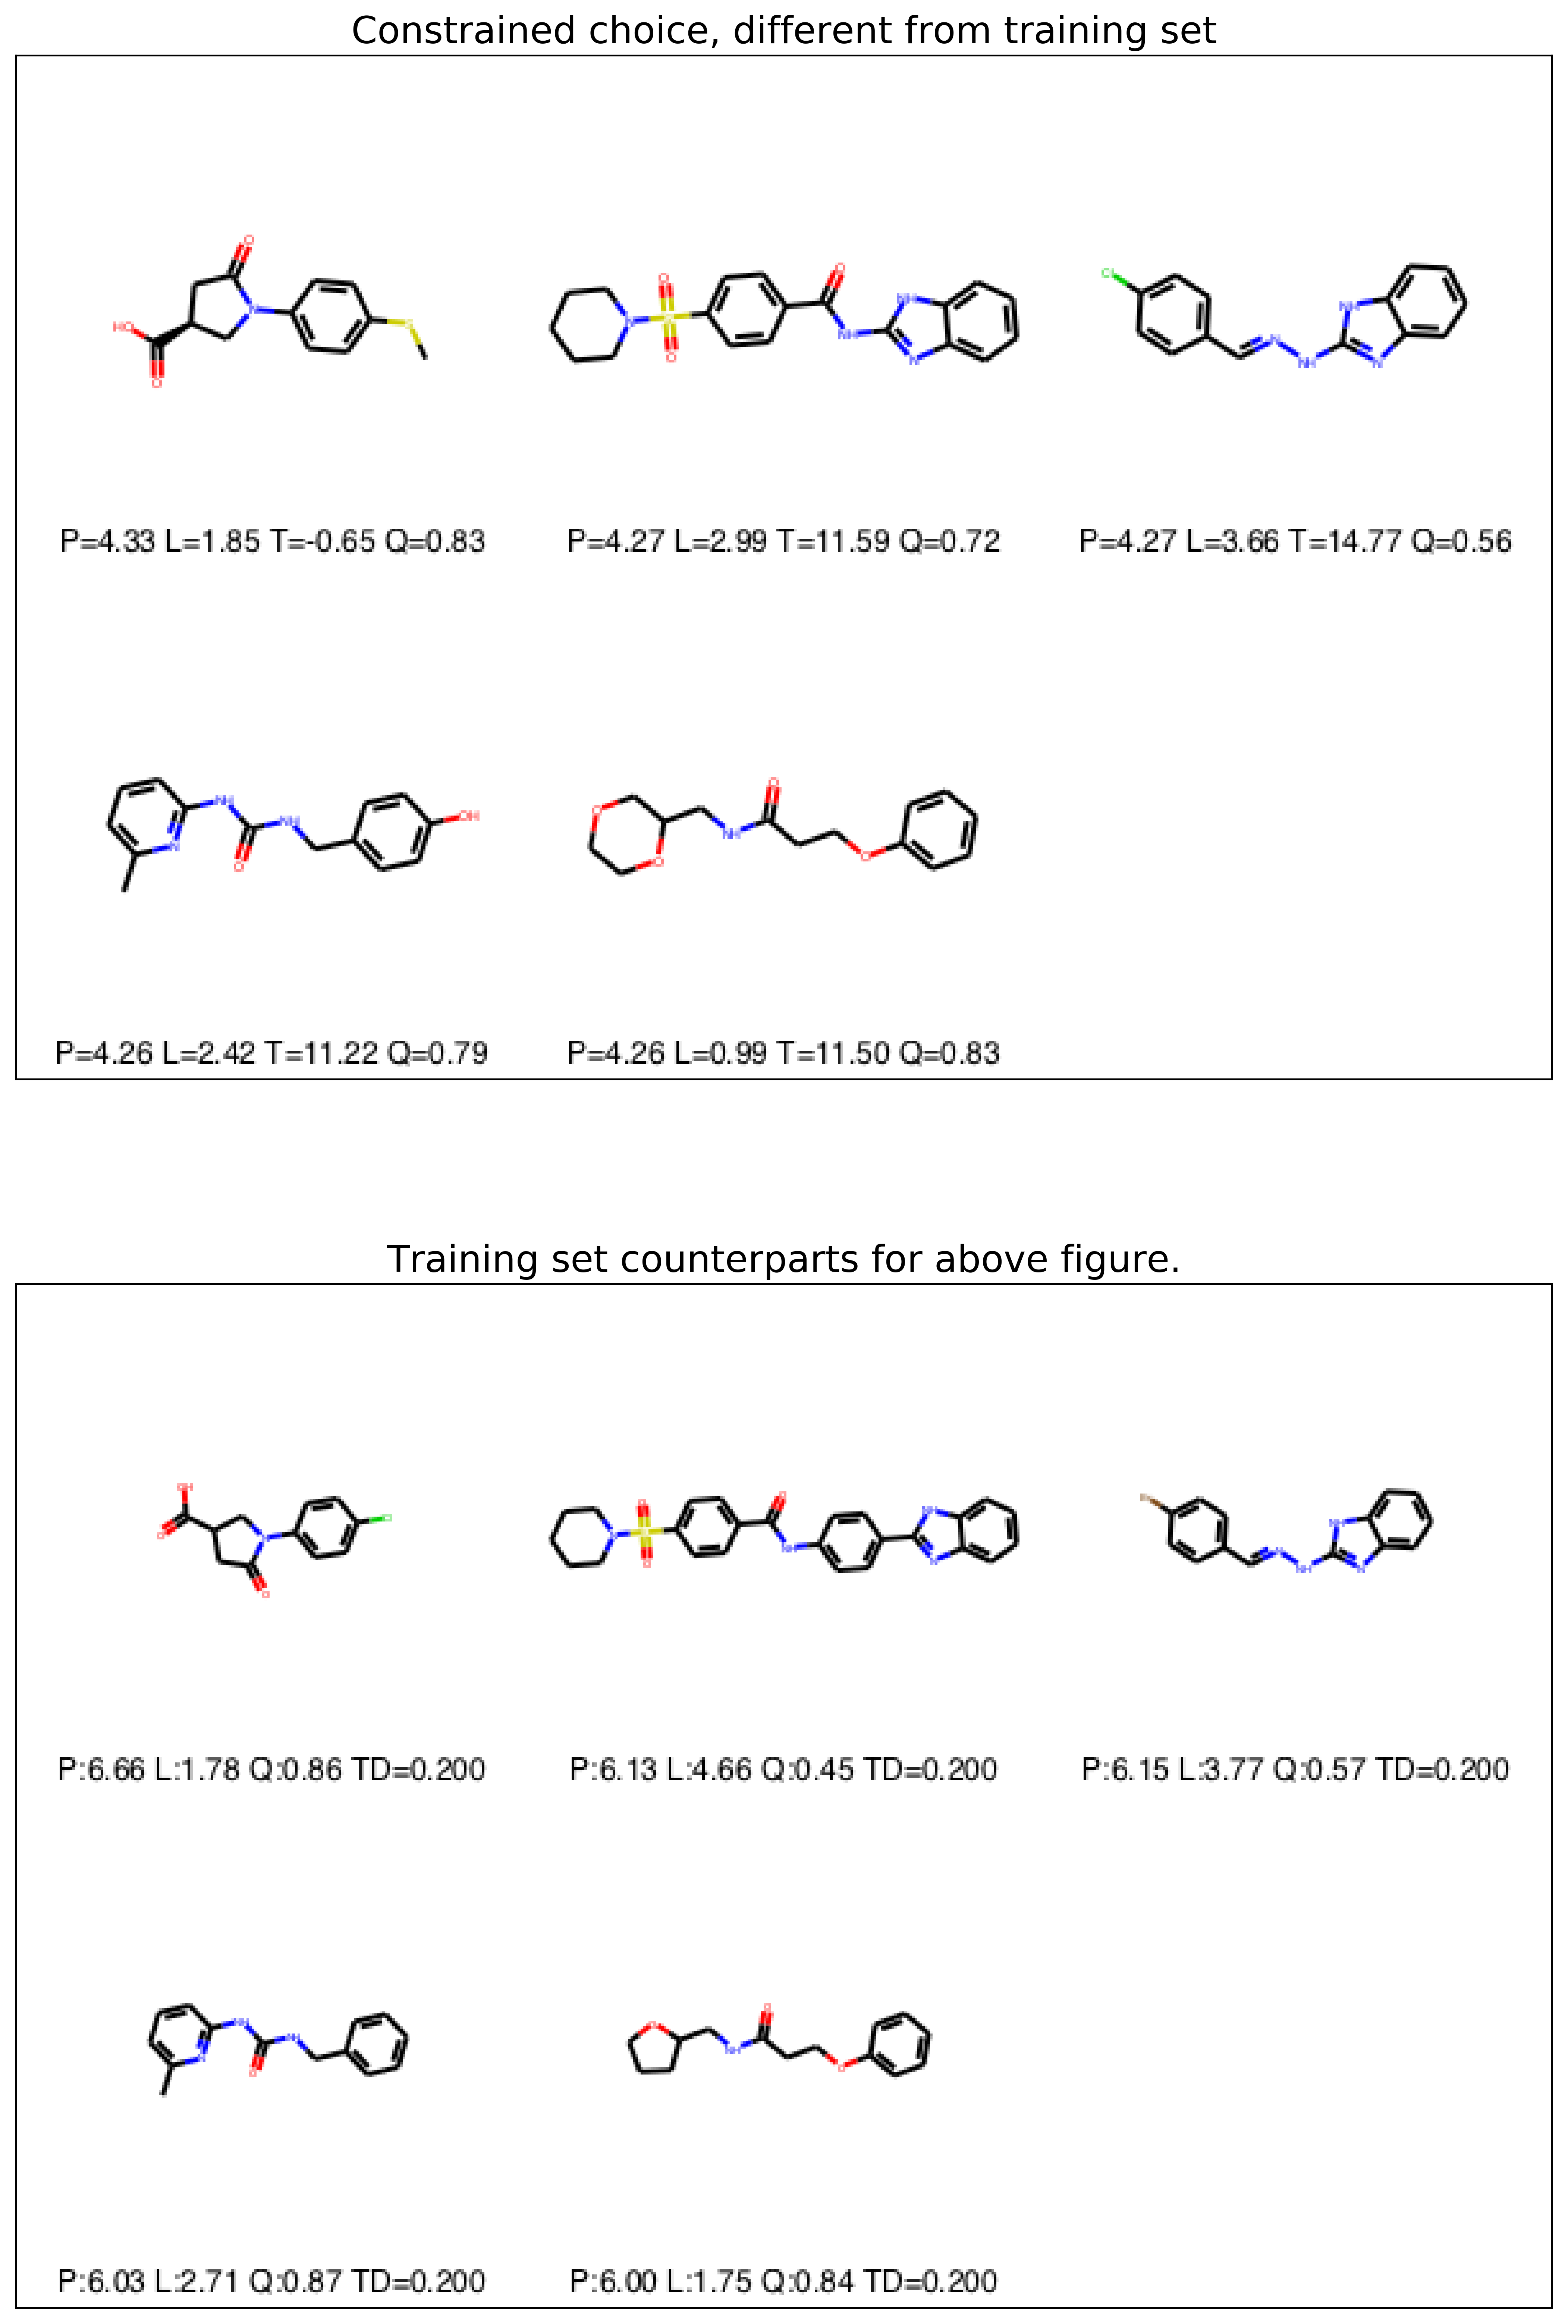

In [98]:
# Figure pot_hist in the paper.
def get_neighbour_labels(vals, min_dists):
    labels = []
    for (i, v) in enumerate(vals):
        it = full_df.loc[v]
        lbl = 'P:%.2f L:%.2f Q:%.2f %s' % (it.POTENCY, it.crippen, it.qed, min_dists[i])
        labels.append(lbl)
        pass
    return labels

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20), dpi=400)
plt.subplot(211)
fig = mp_utils.summarize('BEST_D', 5, check_new=full_df, min_dist=0.2)
plt.imshow(fig)
plt.xticks([])
plt.yticks([])
plt.title('Constrained choice, different from training set')
neighbours, mds = mp_utils.summarize('BEST_D', 5, check_new=full_df, neighbours=True, min_dist=0.2, draw=False)
nl = get_neighbour_labels(neighbours, mds)
plt.subplot(212)
fig = Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in neighbours],legends=nl)
plt.imshow(fig)
plt.xticks([])
plt.yticks([])
_ = plt.title('Training set counterparts for above figure.')
savefig('figures/fig8.png')

### Using our methods to choose the best compounds (drug discovery simulation).


We have earlier papers (reference one in Bioinformatics) about the success of machine learning models in producing enrichment factors.  In this section we're going to focus on the optimization part of our process.

To do this - we'll proceed as follows.  We'll take slightly over half of our TCAMS data to fit our model - leaving 6000 compounds in the 'out-of-sample'.  We think (following reference of the paper where TCAMS data is described) that around one compound in 100 is active against malaria.  

In [99]:
gd = df_tcams_nd.loc[(df_tcams_nd['pXC50_3D7'] >= 7.6) & (df_tcams_nd['PCT_INHIB_HEPG2'] <= 5)]

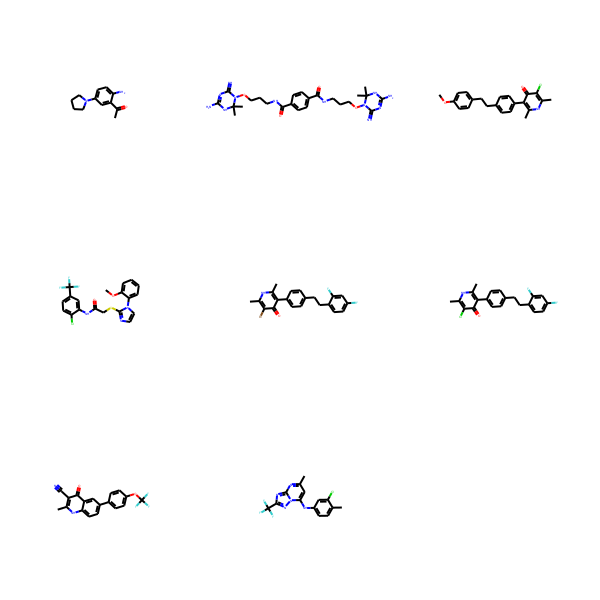

In [100]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in gd.index.values])

Let's do the following test.  We'll fit our models on all the compounds with activity < 7.5 (say).  Reference our Bioinformatics paper showing that splitting on activity is actually better even than trying to directly split using clusters.  Then we'll add N-8 random compounds chosen from Molport.

We'll choose 20 compounds.  The objective function is to maximize the likelihood that _one_ of those compounds is a 'good' one.

First think about the 'random' setup.   You have N compounds, 8 of which are the ones you want.  What is the probability you get (at least) one of these if you choose 20 at random?

Obviously it is:

$1 - \frac{(n-8)(n-7)...(n-15)}{(n(n-1)..(n-7))}$


Let's look at this for various n...

In [103]:
from __future__ import division

def prob_random(n, A=8, T=20):
    x = 1
    num = n - A
    den = n
    for i in range(T):
        x *= num/den
        num -= 1
        den -= 1
    return 1-x

In [104]:
prob_random(100000)

0.0015989363723302175

In [105]:
# We're going to use the compounds with values < 7.5 for fitting (see Bioinformatics paper)
df_fit = df_tcams_nd.loc[(df_tcams_nd['pXC50_3D7'] <= 7.5)]

In [106]:
# potency random forest model
# set seed so replicable
np.random.seed(42)
pot_model = model_dict['rf']['m'](**model_dict['rf']['kw']).fit(
    np.asarray([fp for fp in df_fit.fps.values]), df_fit.pXC50_3D7.values)

In [107]:
# We need the minumum distances (for our model) for the good compounds from the fit dataset...
gd_dists = np.min(cdist(np.asarray([fp for fp in gd.fps.values]), 
                        np.asarray([fp for fp in df_fit.fps.values]), metric='jaccard'), axis=1)

### Preparing predictions on the molport dataset (first ~500K of...)

In [108]:
std_files[0]

'/Users/oliverwatson/evartech/molport/standardn_0'

In [109]:
# first ~ 500K molport compounds...  these already have min dists to the malaria dataset.
mp1 = pd.read_pickle(std_files[0])

In [110]:
blk = []
smile_blk = []

for i in range(1, df_fit.shape[0], 500):
    e = min(i+500, df_fit.shape[0])
    blk.append(np.asarray([x for x in df_fit.fps.values[i:e]]))
    smile_blk.append([x for x in df_fit.index[i:e]])
    pass

print('%d blocks', len(smile_blk))
def add_min_dist(fn, outfn):
    mp_df = pd.read_pickle(fn)
    
    mins = np.ones(mp_df.shape[0], dtype=float)
    amins = np.ones(mp_df.shape[0], dtype=float)
    min_smiles = mp_df.SMILESIS.values.copy()
    mp1_fps = np.asarray([x for x in mp_df.fps.values])
    
    for (i, bl) in enumerate(blk):
        print('Doing', i, '(of ', len(blk), ')')
        bl_min = np.min(cdist(bl, mp1_fps, metric='jaccard'), axis=0)
        amin = np.argmin(cdist(bl, mp1_fps, metric='jaccard'), axis=0)
        
        min_smiles[bl_min < mins] = np.asarray(smile_blk[i])[amin[bl_min < mins]]
        mins = np.minimum(mins, bl_min)
    
    md = pd.Series(mins, index=mp_df.index)
    sm = pd.Series(min_smiles, index=mp_df.index)
    mp_df['min_dist'] = md
    mp_df['min_smile'] = sm
    mp_df.to_pickle(outfn)
    
#add_min_dist(std_files[0], 'test_df')
blk = []
smile_blk = []

('%d blocks', 27)


In [111]:
mp1 = pd.read_pickle('test_df')  # Shared on dropbox for reproducibility
#mp1 = mp1[['SMILESIS', 'fps', 'min_dist', 'min_smile']]
#mp1.to_pickle('test_df')

In [112]:
mp1.head()

,SMILESIS,fps,min_dist,min_smile,prediction
0,COc1cc(C(C)=O)ccc1O,"[True, False, False, False, False, False, Fals...",0.451613,COc1ccc(C(=O)CC(=O)c2ccc(OC)cc2OC)c(OC)c1,3.507272
1,C=CCOc1ccccc1C=O,"[False, False, True, True, False, False, False...",0.577778,C=CCOc1ccccc1CNCC(O)c1cccc(C(F)(F)F)c1,3.502304
2,C=CCc1cccc(C=O)c1O,"[False, False, False, False, False, False, Fal...",0.583333,C=CCc1cccc(CN2CCC(c3cc(=O)[nH]c(-c4ccccn4)n3)C...,3.502323
3,Nc1cnc(Br)cn1,"[False, True, False, False, False, False, Fals...",0.647059,Clc1ccc2c(N3CCN(CCN4CCN(c5ccnc6cc(Cl)ccc56)CC4...,3.502400
4,NC1CCCCC1C(=O)O,"[False, False, False, False, True, True, False...",0.606061,O=C(N[C@H]1CCCC[C@H]1C(=O)O)c1ccccc1,3.502336


In [113]:
mp_fps = np.asarray([fp for fp in mp1.fps.values])

mp_active_potency = pot_model.predict(mp_fps)
mp_frac_active = full_models['frac_act'](mp1.min_dist.values)
mp_rf_beta = full_models['rfb'](mp1.min_dist.values)
molport_predicted_potency = mp_frac_active * (mp_rf_beta * mp_active_potency + (1-mp_rf_beta)*active_level) +\
    (1-mp_frac_active)*inactive_level
molport_predicted_potency[np.isnan(molport_predicted_potency)] = 0.

In [114]:
#mp1['prediction'] = pd.Series(molport_predicted_potency, index=mp1.index)
#mp1.dropna(subset=['prediction']).to_pickle('test_df')

In [115]:
# This should be (super close to) 1.0
stats.regress(molport_predicted_potency[~np.isnan(molport_predicted_potency)], [mp1.prediction.values,])

Coeffs:       1.0005 
R-squared:    0.9026


In [116]:
# This is good - they aren't too close (closer than random for sure). 
#We're not making this too easy for ourselves.
gd_dists

array([ 0.21875   ,  0.30952381,  0.16129032,  0.15384615,  0.37777778,
        0.36363636,  0.36585366,  0.2       ])

In [117]:
gd_fps = np.asarray([fp for fp in gd.fps.values])
gd_active_potency = pot_model.predict(gd_fps)
gd_frac_active = full_models['frac_act'](gd_dists)
gd_rf_beta = full_models['rfb'](gd_dists)
gd_predicted_potency = gd_frac_active * (gd_rf_beta * gd_active_potency + (1-gd_rf_beta)*active_level) +\
    (1-gd_frac_active)*inactive_level

In [118]:
gd_predicted_potency

array([ 4.54830299,  3.63031683,  6.05991429,  6.02046205,  3.52083209,
        3.52294787,  3.5217941 ,  5.02334029])

In [119]:
gd_active_potency

array([ 6.18808633,  6.33155667,  6.71811644,  6.61099261,  6.54450883,
        6.43882727,  6.36045844,  6.39332372])

In [120]:
molport_predicted_potency[np.argsort(molport_predicted_potency)][-20:]

array([ 6.47870004,  6.49359571,  6.49995543,  6.51375873,  6.51724066,
        6.53107218,  6.53257351,  6.5506824 ,  6.62089609,  6.62641871,
        6.62641871,  6.66286704,  6.66286704,  6.66286704,  6.66286704,
        6.74126637,  6.74126637,  6.74126637,  6.7527798 ,  6.7527798 ])

In [121]:
# We'll choose the first num_choice compounds from the first molport file - and then add on
# the 8 good compounds at the end...
num_choice = 100000

In [122]:
def run_experiment(num_choice=100*1000, to_choose=20):
    A = 8 # Number of ones you actually want
    print('Probability of success if random %.5f' % prob_random(num_choice + A, A=A, T=to_choose))
    
    potency = np.concatenate((molport_predicted_potency[:num_choice], gd_predicted_potency))
    
    x = sum(np.argsort(potency)[-to_choose:] > num_choice)
    if (x > 0):
        print('Succeeded: %d found' % x)
    else:
        print('Failed')
    return np.argsort(potency)[-to_choose:]


In [123]:
_ = run_experiment(10000)

Probability of success if random 0.01588
Succeeded: 3 found


In [124]:
_ = run_experiment(20000)

Probability of success if random 0.00797
Succeeded: 2 found


In [125]:
_ = run_experiment(30000)

Probability of success if random 0.00532
Failed


Ok - so the point where this fails is between 20K and 30K.  let's look at this a bit more closely.  In particular, let's look at the top twenty compounds chosen when num_choice=30K.

All of these values should be < 30K, since no 'good' compounds were found - and this is indeed the case.

Now let's look at the min-dists of these values from our training set...

In [128]:
mp1.min_dist.values[idcs]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.05882353,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

What have we discovered so far?  Well - our models perform better than random (statistically significantly - since 0.008 << 0.05), so that is at least somewhat re-assuring.

Unsurprisingly, if we find stuff in our test set that was actually in our training set, then _of course_ we'll say that these compounds are **expected** to be the highest potency (since as discussed earlier in the paper, the potency will degrade fast as we move away from the traing set, due to the contribution of the frac_active component.

In the test case we have set up however, we are not looking for the compounds with **highest expected potency**.  We are looking for compounds **with the highest likelihood of having potency >= 7.6**.  And these are **NOT** the same problem.  If we find a compound in the test set that has the same fingerprint as a compound in our training set, then we will predict a high level of potency. But the **uncertainty** around that value will be very low - and therefore the likelihood that the compound actually has a potency value substantially higher than predicted will also be low.

If the reader examines the earlier fit of potency covariance, looking at the y-value of the intercept in the 'crude fit' - the standard deviation (uncertainty) in the potency prediction for a compound, _given that we have already tested a compound with identical 128-bit fingerprint_ is only 0.15.


Let's look at the potency predictions for our top (expected potency) compounds:

In [129]:
molport_predicted_potency[idcs]

array([ 6.22185056,  6.22243705,  6.22518583,  6.22712405,  6.23247651,
        6.23419159,  6.24267088,  6.25334193,  6.26502828,  6.26514396,
        6.27364649,  6.27859714,  6.29271706,  6.33540647,  6.38123119,
        6.46324214,  6.53257351,  6.62641871,  6.7527798 ,  6.7527798 ])

We see our best (predicted expected potency) compound has a predicted potency of 6.85.  But it has the identical fingerprint to a compound in our test set - therefore the probability that this compound has potency > 7.6 is less than one in a million:

In [130]:
import scipy
1 - scipy.stats.norm.cdf((7.6 - 6.85)/0.27)

0.0027366017862441305

### Using the covariance matrix

At this point it should be clear what we 'should' do.  We simply need to choose the set of 20 compounds from those available such that that set is most likely, given the expected potencies and the covariance structure of the predictions, to contain at least one compound with potency greater than or equal to $7.6$.  However - this is an _extremely_ difficult optimization to run.  There is no simple analytic expression for the objective function, and therefore this objective function would itself need to be simulated (e.g. via Monte Carlo).  The space of choices is extremely large - and thus a standard approach (such as simulated annealing) would be extremely difficult in practice.  We need to make some simplifications.  Let us first examine how we should model the uncertainty of our predictions as a function of the (Tanimoto) distance of a compound from the training set.  

In [131]:
def calc_sigma(distance, mc=False, ia=inactive_level):
    
    fa = frac_active(distance)
    act_sigma = 0.27 + 0.33 * distance
    
    if mc:
        aval = np.random.normal(loc=active_level, scale=act_sigma, size=10000)
        aval[np.random.random(10000) > fa] = ia
        return np.std(aval)
    
    rs = active_level - ia
    
    e_x2 = fa * (rs*rs + act_sigma * act_sigma)
    ex_2 = (fa * rs)**2
    return np.sqrt(e_x2 - ex_2)
    


In [132]:
xv = np.arange(50)/50
sig = np.asarray([calc_sigma(x, mc=True) for x in xv])
siga = np.vectorize(calc_sigma)(xv)

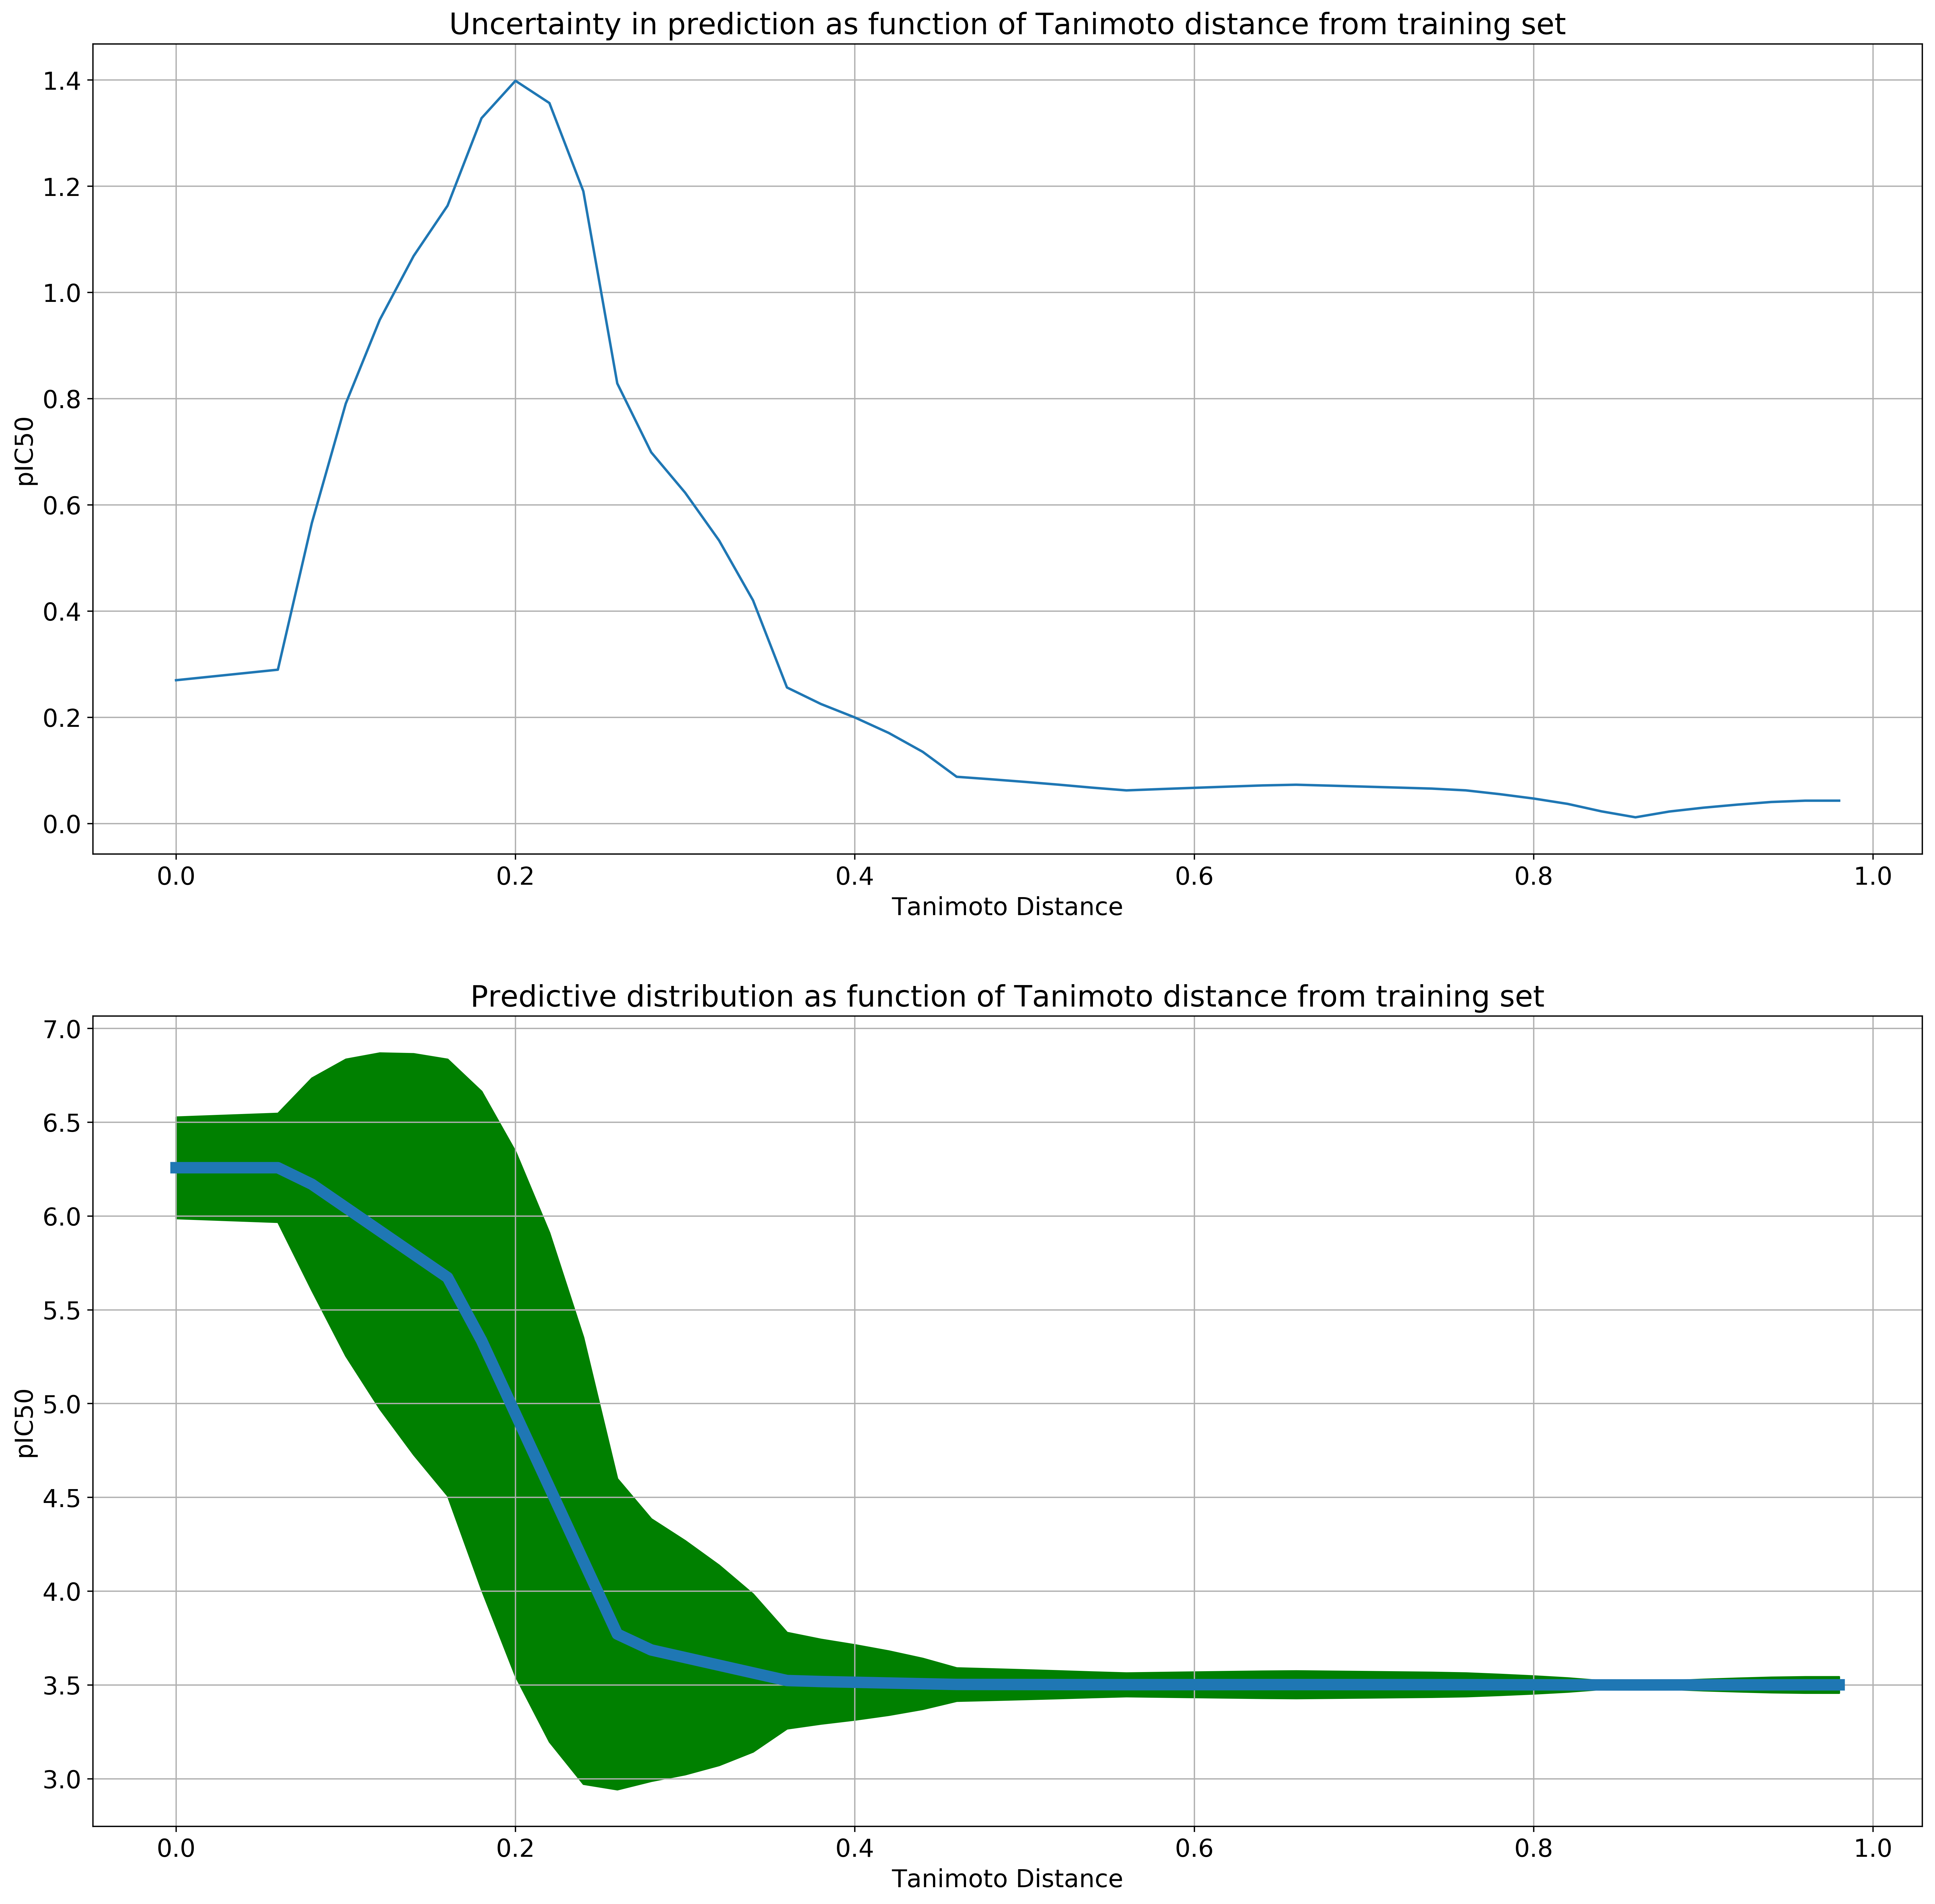

In [133]:
# Figure pot_hist in the paper.
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20), dpi=400)
plt.subplot(211)
plt.plot(xv, siga, label='Standard Deviation (uncertainty in prediction)'); 
plt.xlabel('Tanimoto Distance')
plt.ylabel('pIC50')
plt.grid(True)
plt.title('Uncertainty in prediction as function of Tanimoto distance from training set')
plt.subplot(212)
plt.grid(True)
plt.xlabel('Tanimoto Distance')
yv = (1-frac_active(xv)) * inactive_level + frac_active(xv) * active_level
plt.fill_between(xv, yv - siga, yv + siga, color='g')
plt.plot(xv, yv, linewidth=7.0)
_ = plt.title('Predictive distribution as function of Tanimoto distance from training set')
_= plt.ylabel('pIC50')
savefig('figures/fig9.png')

In [134]:
scipy.stats.norm.logcdf(-5)

-15.064998393988727

In [135]:
def run_experiment2(num_choice=100*1000, to_choose=20, target=7.6):
    A = 8 # Number of ones you actually want
    print('Probability of success if random %.5f' % prob_random(num_choice + A, A=A, T=to_choose))
    
    potency = np.concatenate((molport_predicted_potency[:num_choice], gd_predicted_potency))
    
    distances = np.concatenate((mp1.min_dist.values[:num_choice], gd_dists))
    uncertainties = np.vectorize(calc_sigma)(distances)
    
    log_lik =  scipy.stats.norm.logcdf((potency - target)/uncertainties)
    
    x = sum(np.argsort(log_lik)[-to_choose:] > num_choice)
    if (x > 0):
        print('Succeeded: %d found' % x)
    else:
        print('Failed')
    return np.argsort(log_lik)[-to_choose:]


In [136]:
_ = run_experiment2(50000)

Probability of success if random 0.00320
Succeeded: 2 found


In [137]:
_ = run_experiment2(80000)

Probability of success if random 0.00200
Succeeded: 2 found


In [138]:
_ = run_experiment2(num_choice=200*1000)

Probability of success if random 0.00080
Succeeded: 2 found


In [139]:
_ = run_experiment2(num_choice=300*1000)

Probability of success if random 0.00053
Succeeded: 2 found


In [140]:
_ = run_experiment2(num_choice=480*1000)

Probability of success if random 0.00033
Succeeded: 2 found


## Appendix:  What probability to we give to Artemisinin (and other Endoperoxides)

Endoperoxides list. Bold is some key antimalarials (registered and in dev)

taken from this paper https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5098533/

·         Artemisinin
·         dihydroartemisinin 
·         artemether 
·         arteether 
·         artesunate 
·         artelinic acid
·         aryloxy derivatives
·         deoxyartemisinin 
·         arteflene 
·         artemisinic acid
·         artemisitene 
·         arterolane 
·         artefenomel 
·         artemisone 
·         artemeside

### Check1.  These are _not_ in the TC dataset...

In [141]:
Artemisinin = 'CC1CCC2C(C(=O)OC3C24C1CCC(O3)(OO4)C)C'

In [142]:
artemisin_fp = np.asarray([x for x in utils.get_fp(Artemisinin)])

In [143]:
np.min(cdist(np.asarray([artemisin_fp,]), fpa, metric='jaccard'))

0.58333333333333337

In [144]:
dihydroartemisinin = 'CC1CCC2C(C(OC3C24C1CCC(O3)(OO4)C)O)C'

In [145]:
dihydroartemisinin_fp = np.asarray([x for x in utils.get_fp(dihydroartemisinin)])

In [146]:
np.min(cdist(np.asarray([dihydroartemisinin_fp,]), fpa, metric='jaccard'))

0.59677419354838712

In [147]:
endoperoxide_dict = {
        'Artemisinin' : 'CC1CCC2C(C(=O)OC3C24C1CCC(O3)(OO4)C)C',
        'Dihydroartemisinin' : 'CC1CCC2C(C(OC3C24C1CCC(O3)(OO4)C)O)C',
        'Artemther' : 'CC1CCC2C(C(OC3C24C1CCC(O3)(OO4)C)OC)C',
        'Arteether' : 'CCOC1C(C2CCC(C3C24C(O1)OC(CC3)(OO4)C)C)C',
        'Artesunate' : 'CC1CCC2C(C(OC3C24C1CCC(O3)(OO4)C)OC(=O)CCC(=O)O)C',
        'Artelinic Acid' : 'CC1CCC2C(C(OC3C24C1CCC(O3)(OO4)C)OCC5=CC=C(C=C5)C(=O)O)C',
        'Aryloxy' : 'CC(=O)CC(=O)O', # https://pubchem.ncbi.nlm.nih.gov/compound/96
        'Deoxyartemisinin': 'CC1CCC2C(C(=O)OC3C24C1CCC(O3)(O4)C)C',
        'Arteflene': 'CC1C2CC(CC1=O)C(OO2)(C)C=CC3=C(C=C(C=C3)C(F)(F)F)C(F)(F)F',
        'Artemisinic acid': 'CC1CCC(C2C1CCC(=C2)C)C(=C)C(=O)O',
        'Artemisitene' : 'CC1CCC2C(=C)C(=O)OC3C24C1CCC(O3)(OO4)C',
        'Arterolane' : 'CC(C)(CNC(=O)CC1CCC2(CC1)OC3(C4CC5CC(C4)CC3C5)OO2)N',
        'Artefenomel' : 'C1CC2(CCC1C3=CC=C(C=C3)OCCN4CCOCC4)OC5(C6CC7CC(C6)CC5C7)OO2',
        'Artemisone' : 'CC1CCC2C(C(OC3C24C1CCC(O3)(OO4)C)N5CCS(=O)(=O)CC5)C',
            #'Artemeside' : '', - can't find the smile
}

In [148]:
for endo, smile in endoperoxide_dict.items():
    md = np.min(cdist(np.asarray([utils.get_fp(smile),]), fpa, metric='jaccard'))
    print ('%35s %9.3f' % (endo, md))

                          Arteether     0.586
                         Artesunate     0.578
                          Arteflene     0.531
                        Artefenomel     0.491
                 Dihydroartemisinin     0.597
                          Artemther     0.600
                   Artemisinic acid     0.587
                       Artemisitene     0.557
                     Artelinic Acid     0.514
                        Artemisinin     0.583
                            Aryloxy     0.643
                         Arterolane     0.617
                   Deoxyartemisinin     0.656
                         Artemisone     0.580


## Appendix (Not used).  Selecting optimal subsets using stochastic annealing and full covariance matrix

In [149]:
def get_vcv(fp_array):
    N = fp_array.shape[0]
    return 0.55**2 * np.ones((N, N)) - (corr_f(squareform(pdist(fp_array, metric='jaccard'))) - 0.15*np.eye(N))**2

In [150]:
from numpy.random import multivariate_normal

def neg_prob_success(pot_array, fp_array, thresh=7.6, num_tries=20000, var_scale=1.):
    """
    Use monte carlo to estimate the probability of having at leastone compound with
    potency > thresh if the potencies are distributed with a multivariate normal
    N(pot_array, get_vcv(fp_array))
    """
    N = pot_array.shape[0]
    return -1 * np.sum(np.sum((multivariate_normal(pot_array, 
                                              var_scale*get_vcv(fp_array), num_tries) > thresh), 
                              axis=1)> 0)/num_tries

In [151]:
def stochastic_search(my_pot, my_fps, num_to_choose=20, temp=0.997, tmax=10000, lkw={},
                      init=None, loss_func=neg_prob_success, debug=False, tol=0.005):
    
    temperature = temp
    
    size = my_pot.shape[0]

    if init is None:
        candidates = np.random.choice(np.arange(size), num_to_choose, replace=False)
    else:
        candidates = init
        pass
    
    time = 0
    
    while time < tmax:
        
        if time % 500 == 0:
            print('Time now %d - value %.5f' % (time, loss_func(my_pot[candidates], my_fps[candidates], **lkw)))
            pass
        
        choices = np.delete(np.arange(size), candidates)
        old_candidate = np.random.choice(candidates, 1)
        new_candidate = np.random.choice(choices, 1)
        
        new_candidates = candidates.copy()
        new_candidates[new_candidates == old_candidate] = new_candidate
        
        old_loss = loss_func(my_pot[candidates], my_fps[candidates], **lkw)
        new_loss = loss_func(my_pot[new_candidates], my_fps[new_candidates], **lkw)
        
        if old_loss - tol > new_loss:
            candidates = new_candidates
            if debug:
                print('Old loss: %.4f - new loss: %.4f - swapping' % (old_loss, new_loss))
        else:
            temperature = temp**(time+1)
            rnd = np.random.random()
            if rnd < temperature:
                if debug:
                    print('Old loss: %.4f - new loss: %.4f - temp: %.4f rand: %.4f swapping' %
                         (old_loss, new_loss, temperature, rnd))
                candidates = new_candidates
            pass
        pass
                    
        time+=1
        pass
    
    print ('At tmax, value was %6.4f' % loss_func(my_pot[candidates], my_fps[candidates], **lkw))
    return candidates